In [1]:
import sys
sys.path.append("..")

from newutils.pickleloader import load_pickle, dump_pickle
import newutils.preprocess as preprocess
import newutils.fdt as fdt
import newutils.mhue as mhue
import newutils.homogeneity as homogeneity
import newutils.stability as stability
import newutils.match_groundtruth as match_groundtruth
import newutils.region as region
import newutils.bound as bound

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from tqdm.notebook import tqdm
import talib
import pandas as pd
import math
import os
import re
from scipy.stats import gaussian_kde
from scipy.signal import argrelmin,argrelmax
from scipy.ndimage import distance_transform_cdt

import warnings
warnings.filterwarnings("ignore")

In [2]:
importlib.reload(bound)

<module 'newutils.bound' from '../newutils/bound.py'>

In [3]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 100

In [4]:
def pre_run(param):
    img_idx = param['index']
    
    path = '../image/t1/'
    filenames = ['outImg' + str(idx) + '.bmp' for idx in img_idx]
    img_org_lst = [cv.imread(path+filename,0) for filename in filenames]
    truth_img_lst = [cv.imread('../image/groundtruth/('+str(idx)+').bmp',0) for idx in img_idx]
    
    # get best threshold
    best_t = match_groundtruth.get_best_t(img_org_lst,img_idx,truth_img_lst)
    
    img_lst = []
    scharr_lst = []
    img_bdts_o = []
    img_bdts_b = []
    stab_lst = []
    scharr_b_lst = []
    delta_lst = []
    for lst_idx, img in enumerate(img_org_lst):
        idx = img_idx[lst_idx]
        print("Index: {}, ".format(idx),end="")
        
        # Mask and crop
        print("Mask..",end="")
        img = preprocess.mask_image(img, beta=10)
        img_lst.append(img)
        
        # Grad
        print("Gradient Map..",end="")
#         img_equalize = cv.equalizeHist(img)
#         scharr = homogeneity.get_scharr(img_equalize)
        scharr = homogeneity.get_scharr(img)
        scharr = homogeneity.rank_normalize(scharr)
        scharr_lst.append(scharr)
        
        # BDT
        print("BDT..",end="")
        inten_min, inten_max = np.min(img), np.max(img)
        n_pixels = np.size(img)
        t1, t2 = inten_min + 2, inten_max - 2
        bdts_o = []
        bdts_b = []
        for t in range(t1, t2):
            # object
            _, src = cv.threshold(img, t, 255, cv.THRESH_BINARY)
            bdt_o = distance_transform_cdt(src,return_distances=True)
            bdts_o.append(bdt_o)
            # background
            src = 255-src
            bdt_b = distance_transform_cdt(src,return_distances=True)
            bdts_b.append(bdt_b)
        img_bdts_o.append(bdts_o)
        img_bdts_b.append(bdts_b)
        
        # Stability
        print("Stability..",end="")
        stab = stability.get_stability(img,bdts_o)
        stab_lst.append(stab)
        
        # Bounding Grad
        print("Bounded Gradient Map..")
        scharr_b,delta = bound.get_scharr_bounding(img, scharr, bdts_o, 60)
        scharr_b_lst.append(scharr_b)
        delta_lst.append(delta)
        
    param['img_org'] = img_org_lst
    param['best_t'] = best_t
    param['img'] = img_lst
    param['gt'] = truth_img_lst
    param['scharr'] = scharr_lst
    param['bdts_o'] = img_bdts_o
    param['bdts_b'] = img_bdts_b
    param['stab'] = stab_lst
    param['scharr_b'] = scharr_b_lst
    param['delta'] = delta_lst
    return param

In [5]:
param = {}
param['index'] = [5,14,21,30,47,60,74,83,95,106,112,125]
param = pre_run(param)

Finding best threshold by error rate
Index: 5, done. Best threshold at: 54
Index: 14, done. Best threshold at: 58
Index: 21, done. Best threshold at: 57
Index: 30, done. Best threshold at: 59
Index: 47, done. Best threshold at: 62
Index: 60, done. Best threshold at: 62
Index: 74, done. Best threshold at: 64
Index: 83, done. Best threshold at: 64
Index: 95, done. Best threshold at: 62
Index: 106, done. Best threshold at: 68
Index: 112, done. Best threshold at: 67
Index: 125, done. Best threshold at: 68
Index: 5, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 14, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 21, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 30, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 47, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 60, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Index: 74, Mask..Gradient Map..BDT..Stability..Bounded Gradient Map..
Inde

In [6]:
param.keys()

dict_keys(['index', 'img_org', 'best_t', 'img', 'gt', 'scharr', 'bdts_o', 'bdts_b', 'stab', 'scharr_b', 'delta'])

In [7]:
def MHUE(param):
    img_idx = param['index']
    img_lst = param['img']
    scharr_lst = param['scharr']
    
    uncertainty_lst = []
    mhue_lst = []
    mhue_t = []
    
    for idx,img in enumerate(img_lst):
        uncertainty = mhue.get_uncertainty(img)
        scharr = scharr_lst[idx]
        mhue_img = mhue.get_HU(uncertainty=uncertainty, homogeneity=scharr)
        mhue_lst.append(mhue_img)
        mhue_img = list(map(lambda x:np.sum(x), mhue_img))
        mhue_mint = np.argmin(mhue_img) + np.min(img) + 2
        print('Index: {}, MHUE threshold at: {}.'.format(img_idx[idx], mhue_mint))
        mhue_t.append(mhue_mint)
        uncertainty_lst.append(uncertainty)
    
    param['uncertainty'] = uncertainty_lst
    param['mhue'] = mhue_lst
    param['mhue_t'] = mhue_t
    
    return param

In [8]:
param = MHUE(param)

Index: 5, MHUE threshold at: 75.
Index: 14, MHUE threshold at: 75.
Index: 21, MHUE threshold at: 80.
Index: 30, MHUE threshold at: 83.
Index: 47, MHUE threshold at: 89.
Index: 60, MHUE threshold at: 94.
Index: 74, MHUE threshold at: 99.
Index: 83, MHUE threshold at: 98.
Index: 95, MHUE threshold at: 99.
Index: 106, MHUE threshold at: 103.
Index: 112, MHUE threshold at: 103.
Index: 125, MHUE threshold at: 103.


In [9]:
# Region score: gradient map & stability weighted uncertainty
def region_score(param):
    img_idx = param['index']
    img_lst = param['img']
    scharr_lst = param['scharr']
    stab_lst = param['stab']
    img_bdts_o = param['bdts_o']
    img_bdts_b = param['bdts_b']
    delta_lst = param['delta']
    
    regions = []
    r_recons = []
    region_t = []
    uncertaintyws = []
    
    for idx,img in enumerate(img_lst):
        uncertaintyw = mhue.get_uncertainty(img, off_center=True, info_w=True, stabs=stab_lst[idx], 
                                            bdts_o=img_bdts_o[idx], bdts_b=img_bdts_b[idx],kernel_size=31,sigma=0.5)
        uncertaintyws.append(uncertaintyw)
        scharr = scharr_lst[idx]
        delta = delta_lst[idx]
        region_i = region.get_score(img,uncertaintyw,scharr,kernel_size=5,bounding=False)
        regions.append(region_i)
        r_recon = region.vmd_extract(region_i,var_min=0.01)
        r_recons.append(r_recon)
        best_region_t = argrelmax(r_recon,order=delta//2)[0] + np.min(img) + 2
        region_t.append(best_region_t)
        print('Index: {}, Region score possible threshold: {}.'.format(img_idx[idx], best_region_t))
    
    param['uncertaintyw'] = uncertaintyws
    param['region'] = regions
    param['r_recon'] = r_recons
    param['region_t'] = region_t
    return param

In [12]:
param = region_score(param)

Index: 5, Region score possible threshold: [ 88 142 159 187].
Index: 14, Region score possible threshold: [ 72  96 189].
Index: 21, Region score possible threshold: [ 74 100 191].
Index: 30, Region score possible threshold: [ 72 103 130 194].
Index: 47, Region score possible threshold: [ 70 110 140 169 197].
Index: 60, Region score possible threshold: [ 66 108 141 177].
Index: 74, Region score possible threshold: [ 74 111 144 192].
Index: 83, Region score possible threshold: [ 72 143].
Index: 95, Region score possible threshold: [ 73 148 189].
Index: 106, Region score possible threshold: [ 74 108 150 180 209].
Index: 112, Region score possible threshold: [ 83 114 150 178 208].
Index: 125, Region score possible threshold: [76].


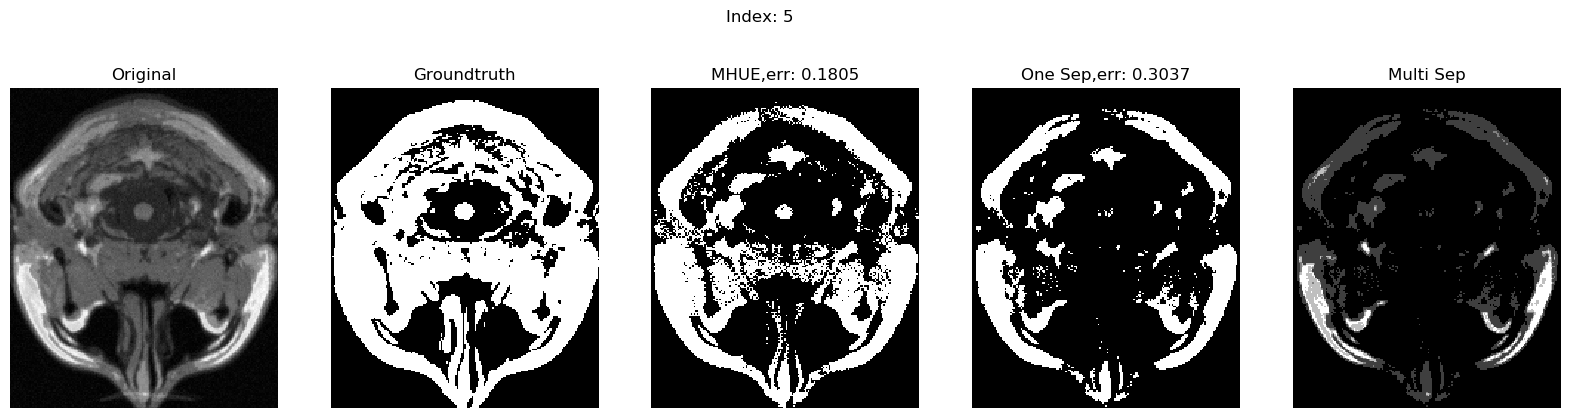

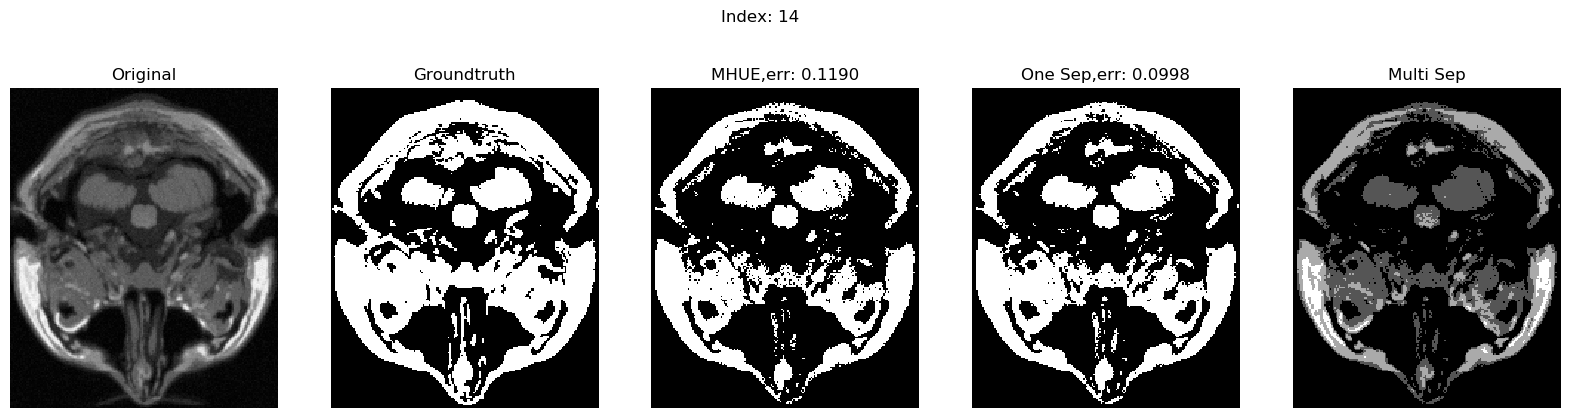

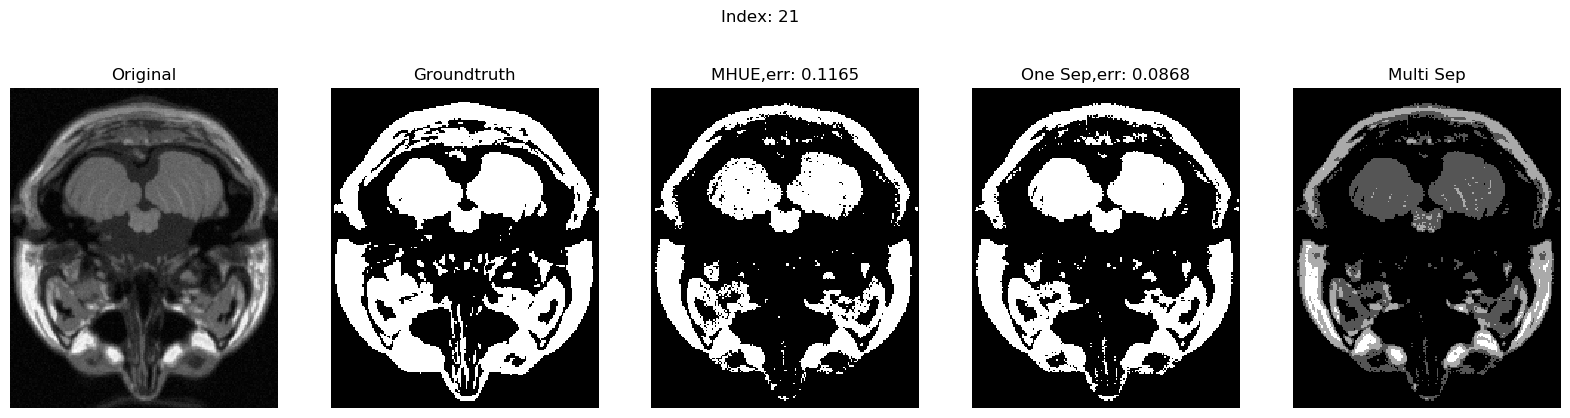

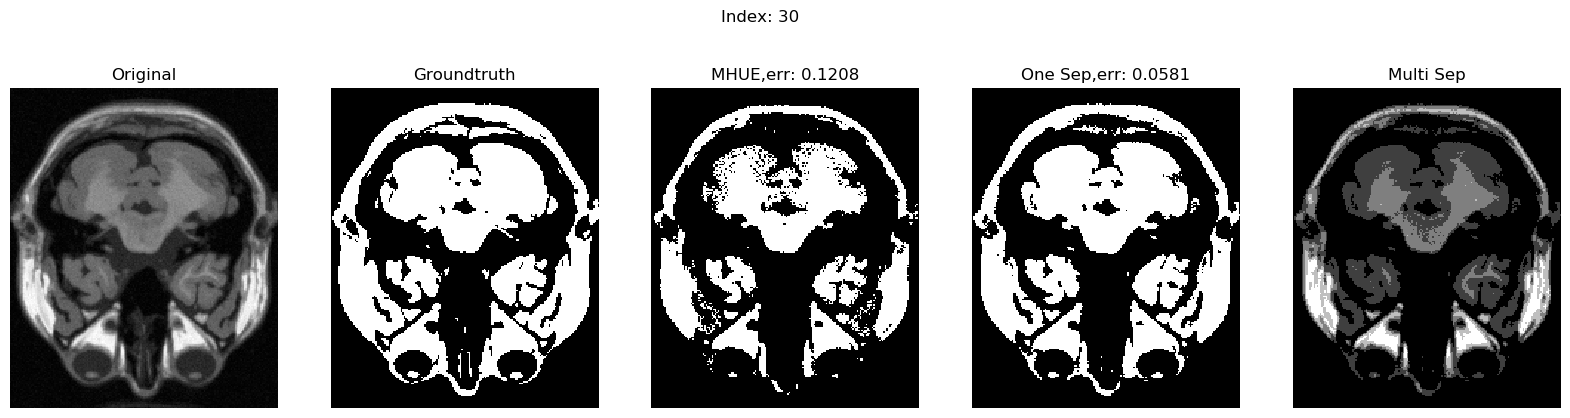

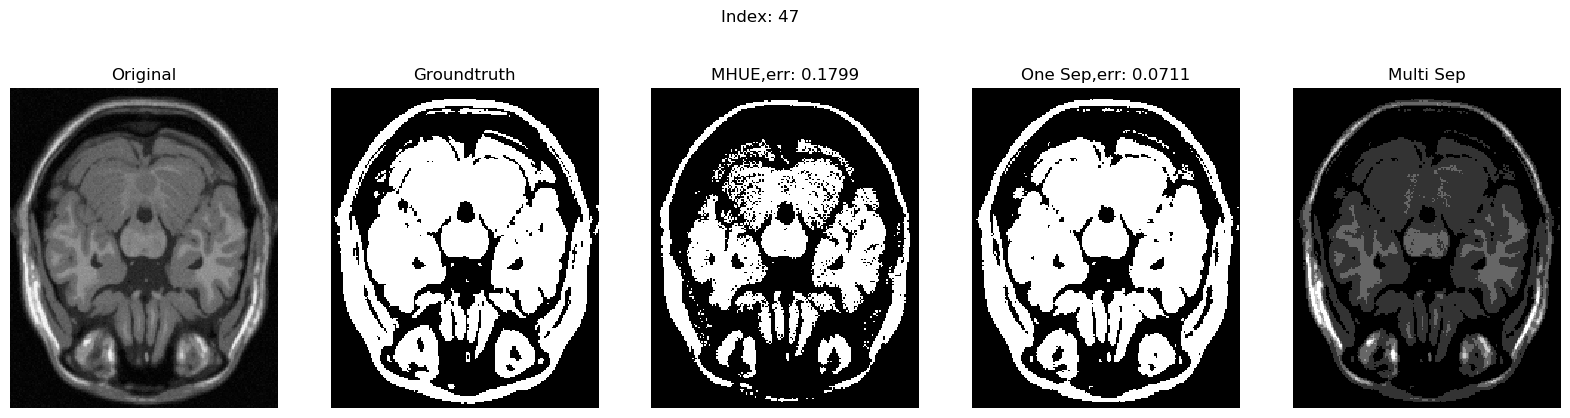

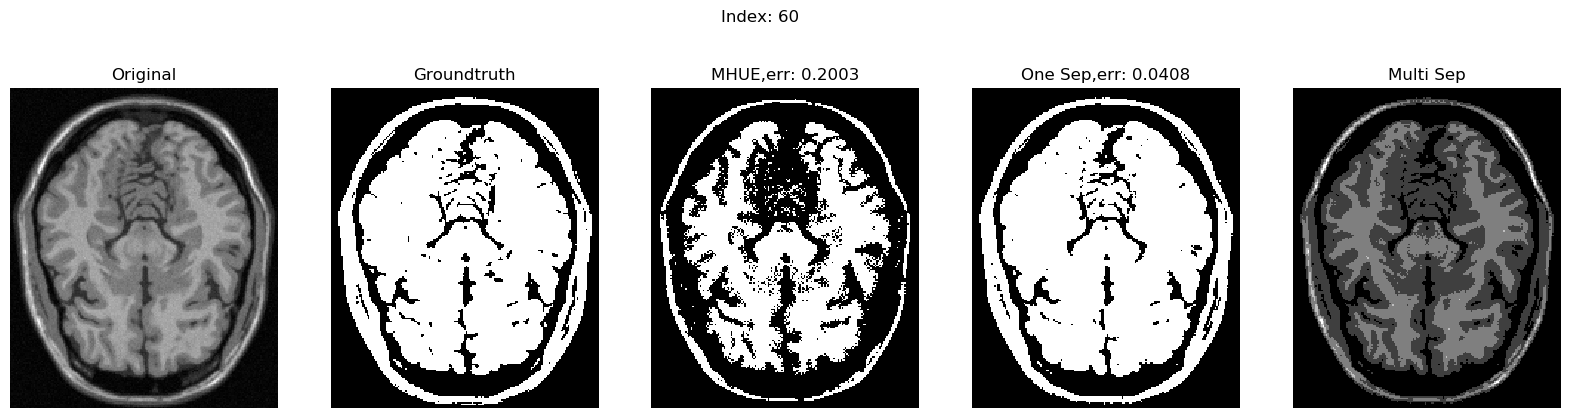

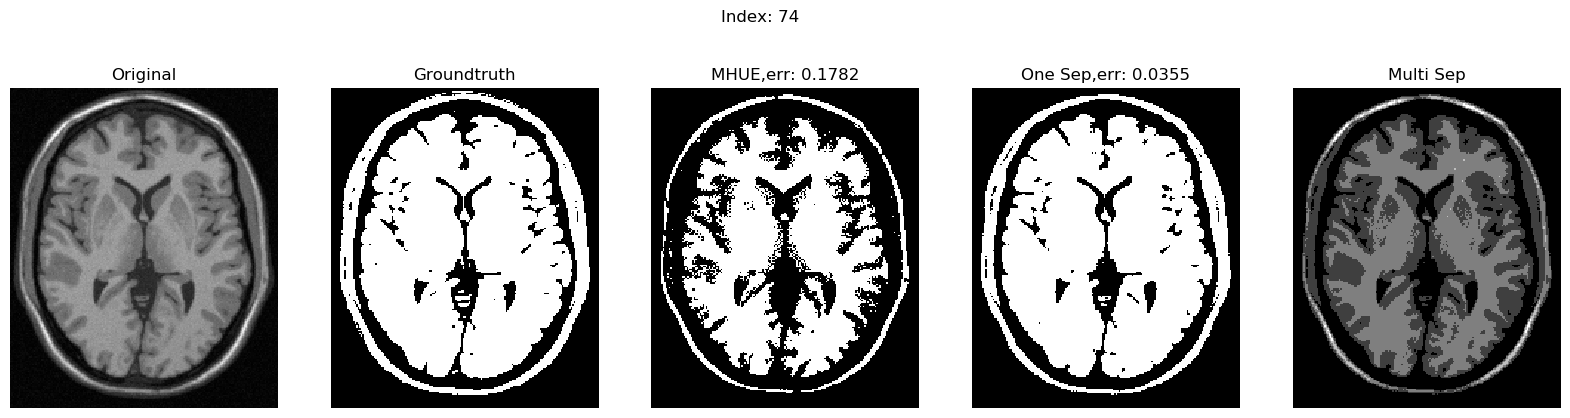

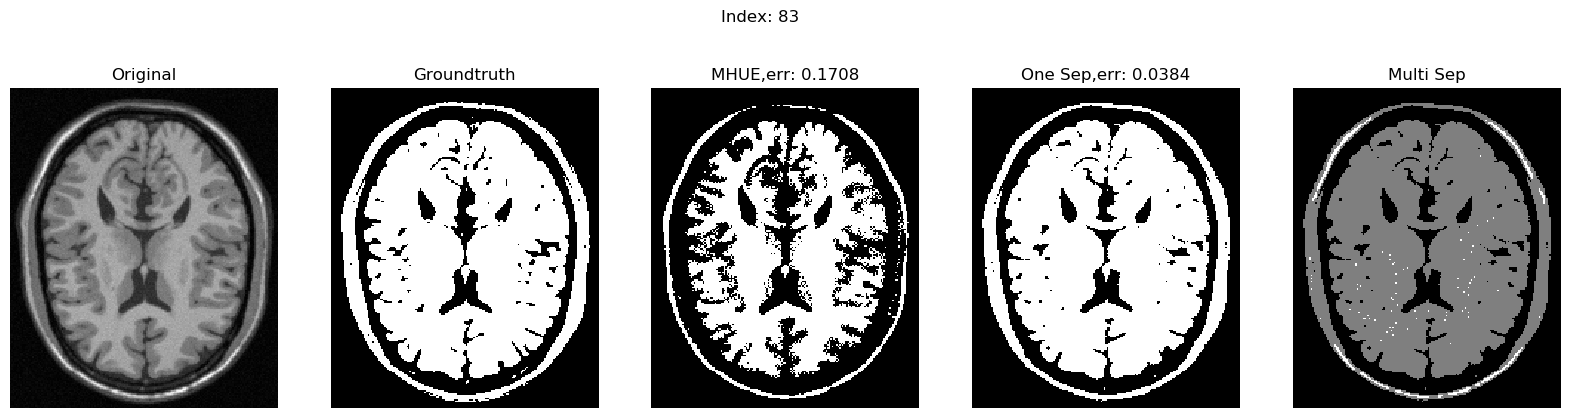

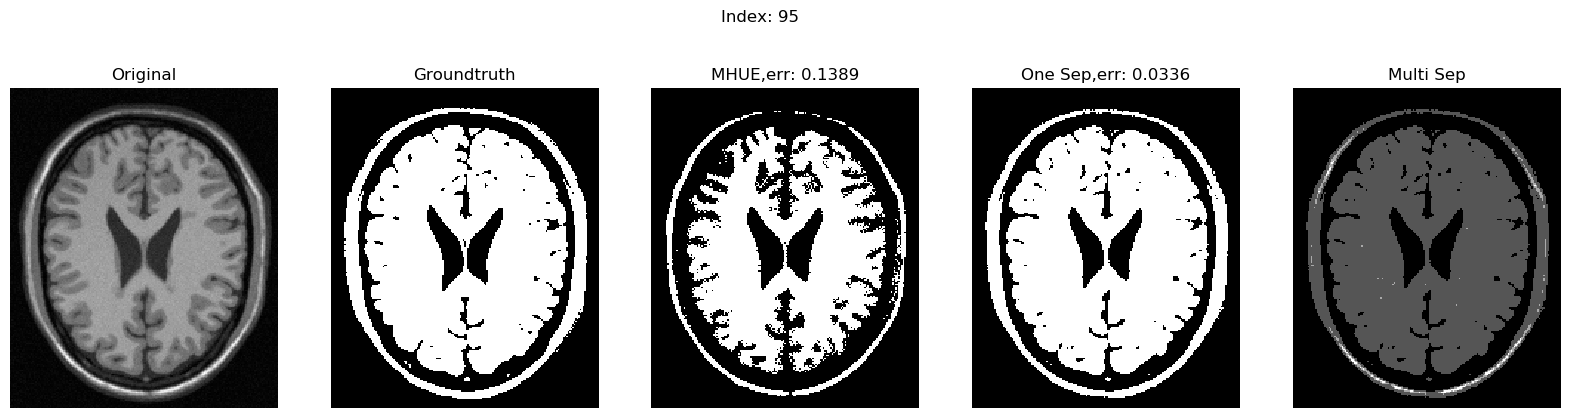

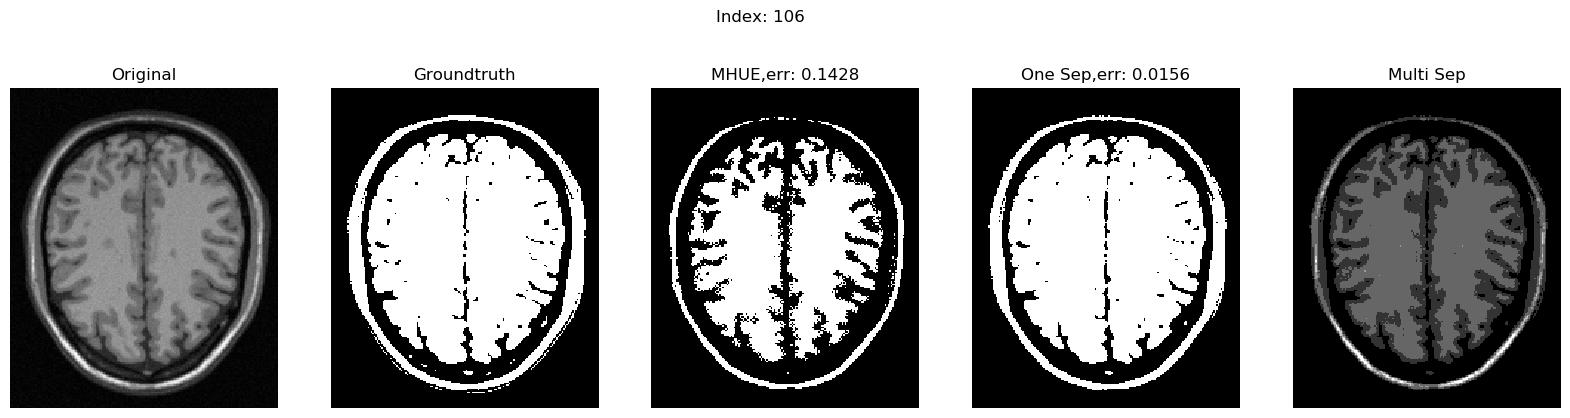

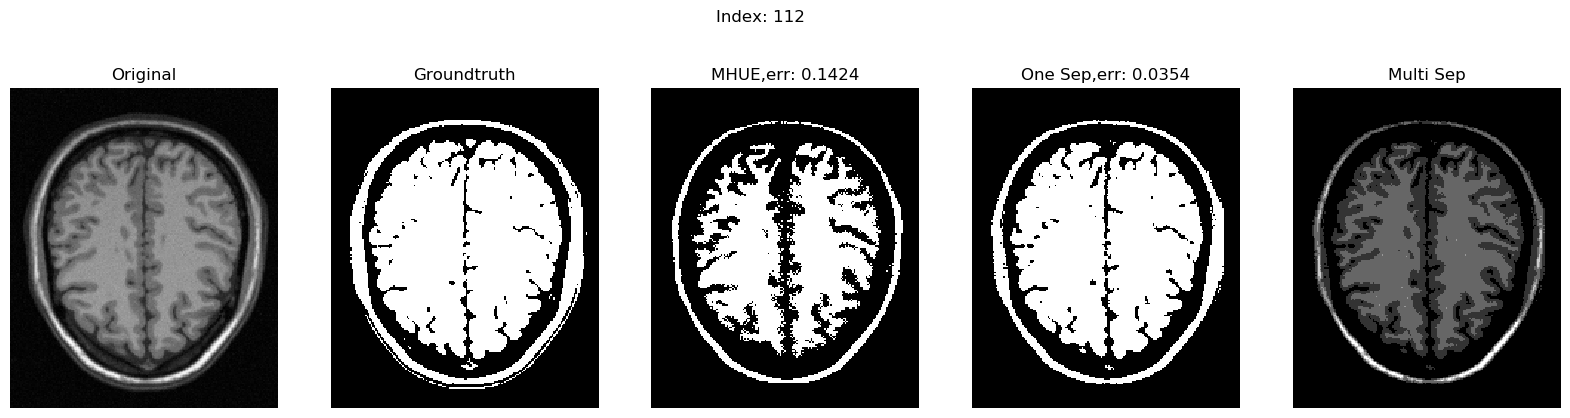

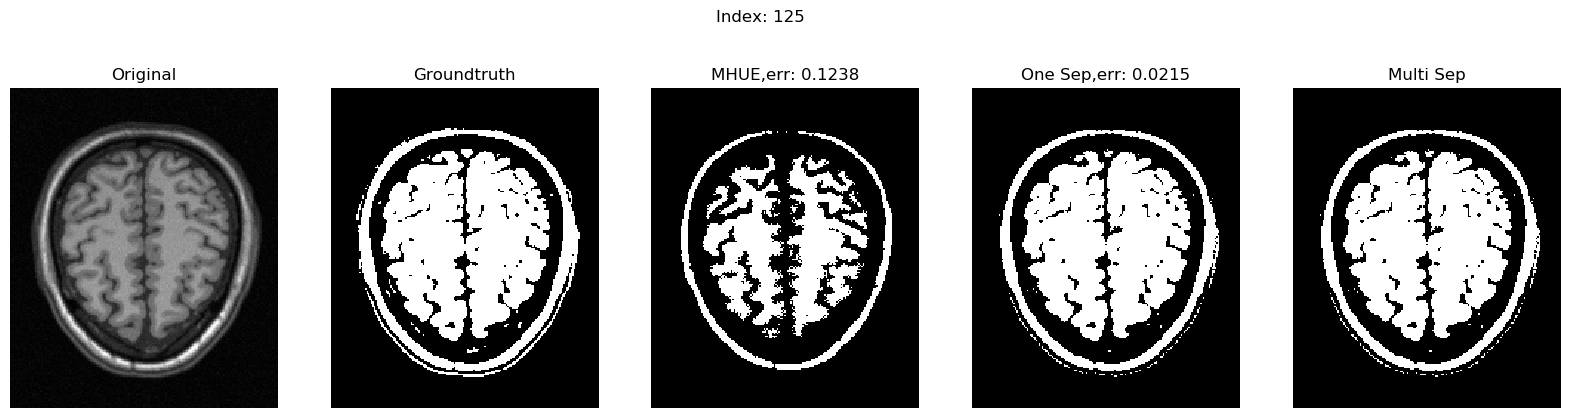

In [14]:
img_idx = param['index']
img_lst = param['img_org']
mhue_t = param['mhue_t']
region_t = param['region_t']
gt_lst = param['gt']
for idx,img in enumerate(img_lst):
    region_maxt = region_t[idx]
    mhue_mint = mhue_t[idx]
    gt = gt_lst[idx]
    plt.figure(figsize=(20,5))
    plt.suptitle('Index: {}'.format(img_idx[idx]))
    plt.subplot(151)
    plt.axis('off')
    plt.title('Original')
    plt.imshow(img,cmap='gray')
    plt.subplot(152)
    plt.axis('off')
    plt.title('Groundtruth')
    plt.imshow(gt,cmap='gray')
    
    plt.subplot(153)
    plt.axis('off')
    _,tmp = cv.threshold(img,mhue_mint,255,0)
    err = match_groundtruth.get_error_rate(tmp,gt)
    plt.title('MHUE,err: {:.4f}'.format(err))
    plt.imshow(tmp,cmap='gray')
    
    n_sep = region_maxt.size
    sep = np.zeros(shape=img.shape) * 255
    for n in range(n_sep):
        _,tmp = cv.threshold(img,region_maxt[n],255,0)
        if n==0:
            plt.subplot(154)
            err = match_groundtruth.get_error_rate(tmp,gt)
            plt.axis('off')
            plt.title('One Sep,err: {:.4f}'.format(err))
            plt.imshow(tmp,cmap='gray')
        sep[np.where(tmp==255)] = int(255*(n+1)/n_sep)
    plt.subplot(155)
    plt.axis('off')
    plt.title('Multi Sep')
    plt.imshow(sep,cmap='gray')

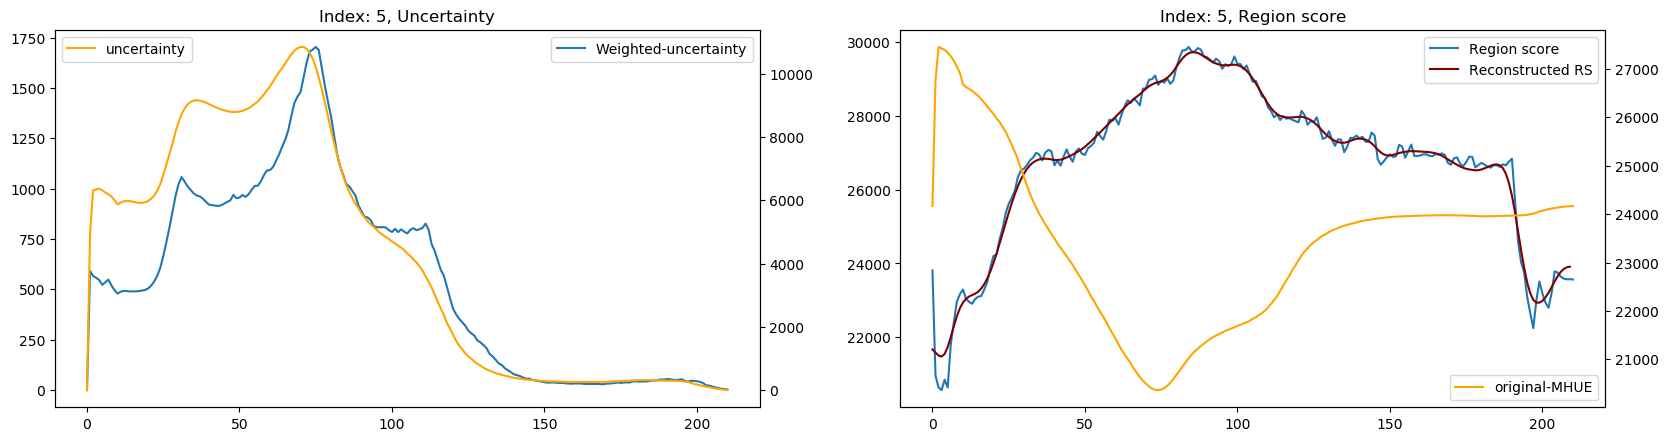

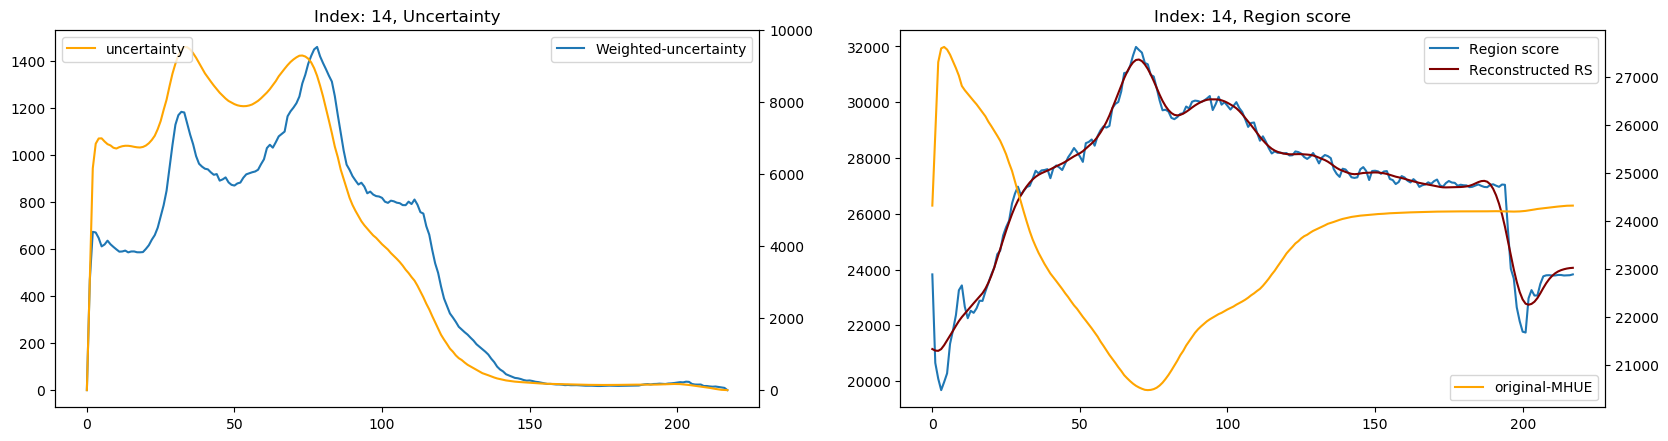

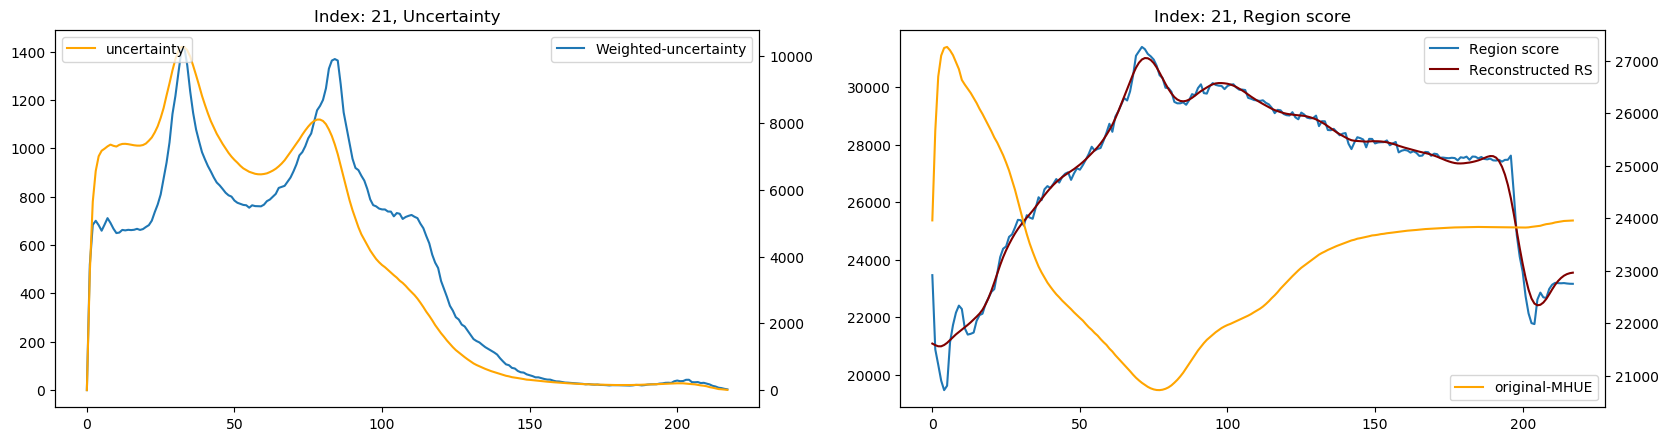

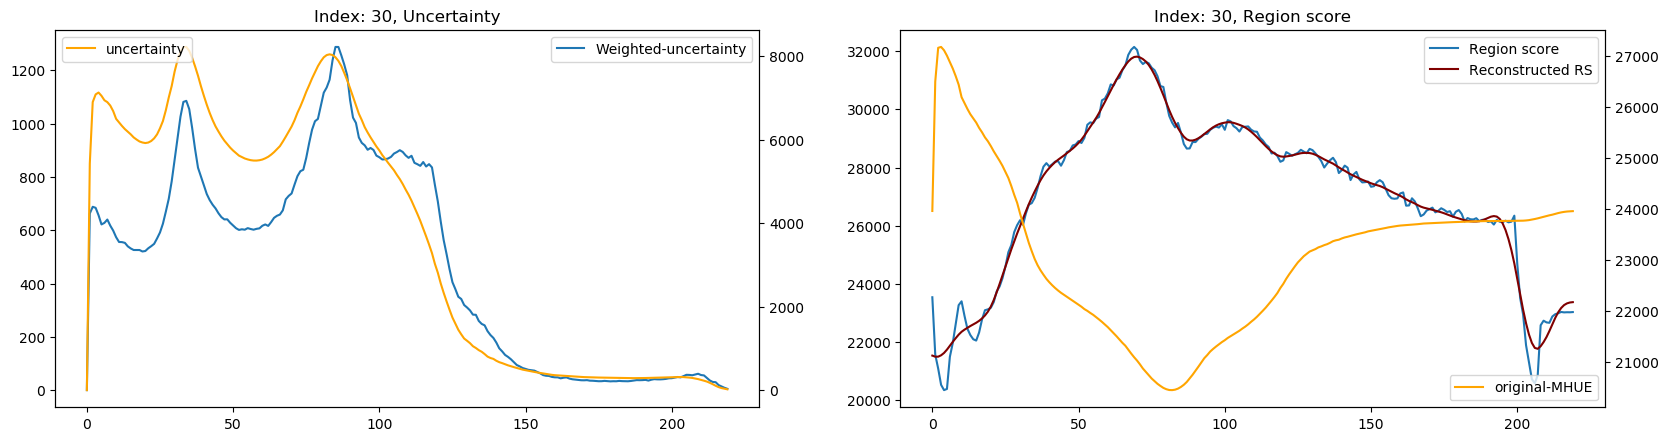

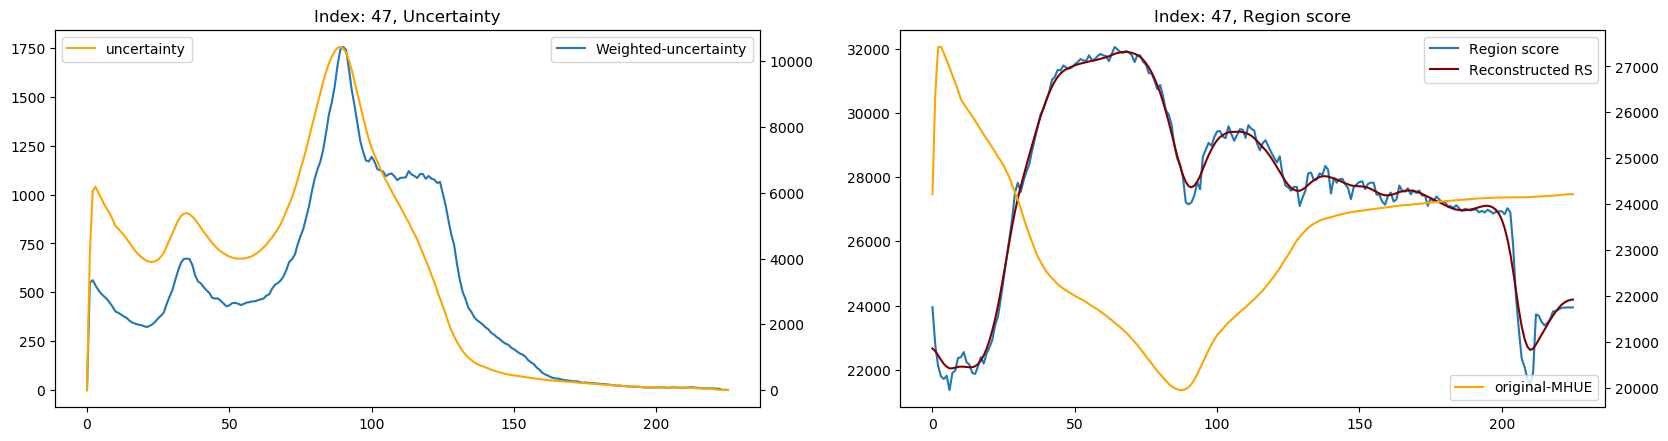

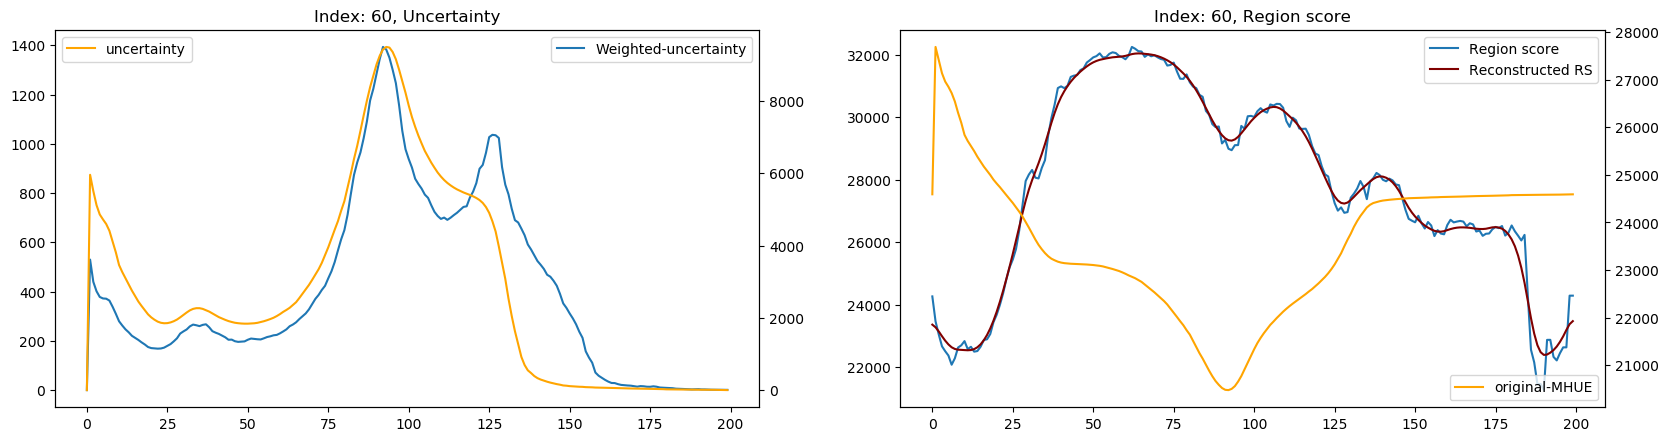

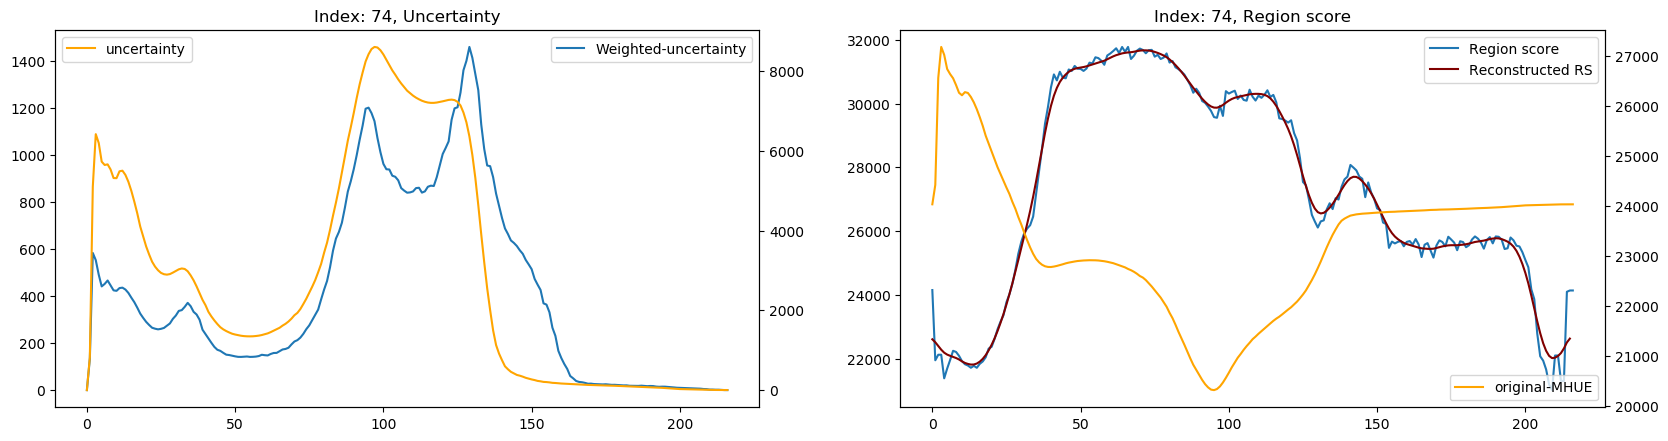

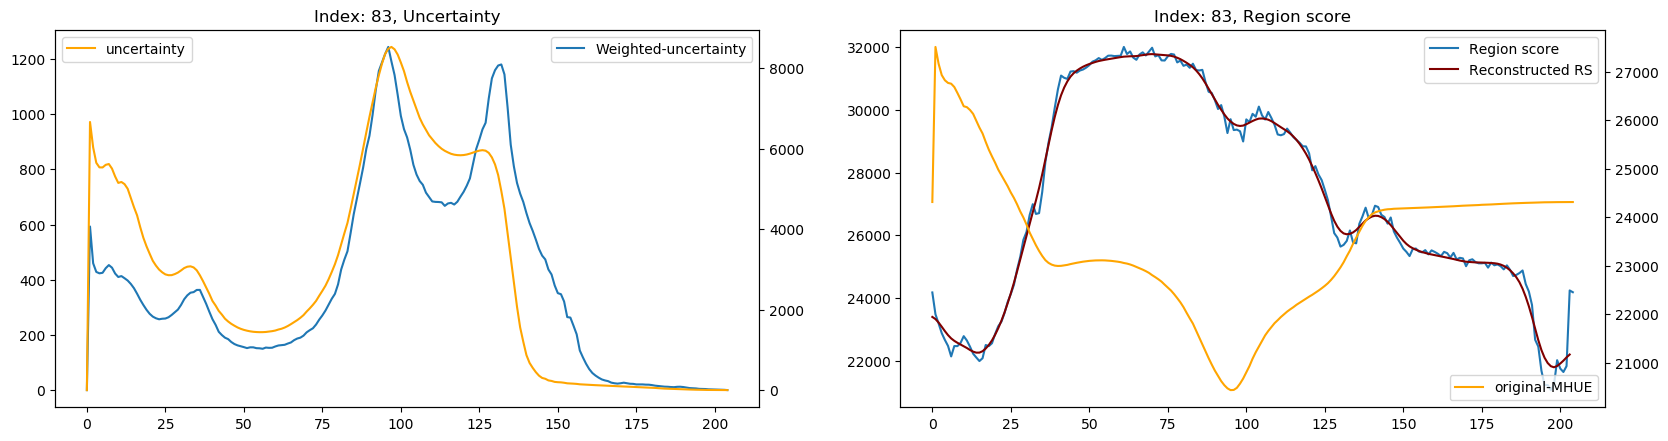

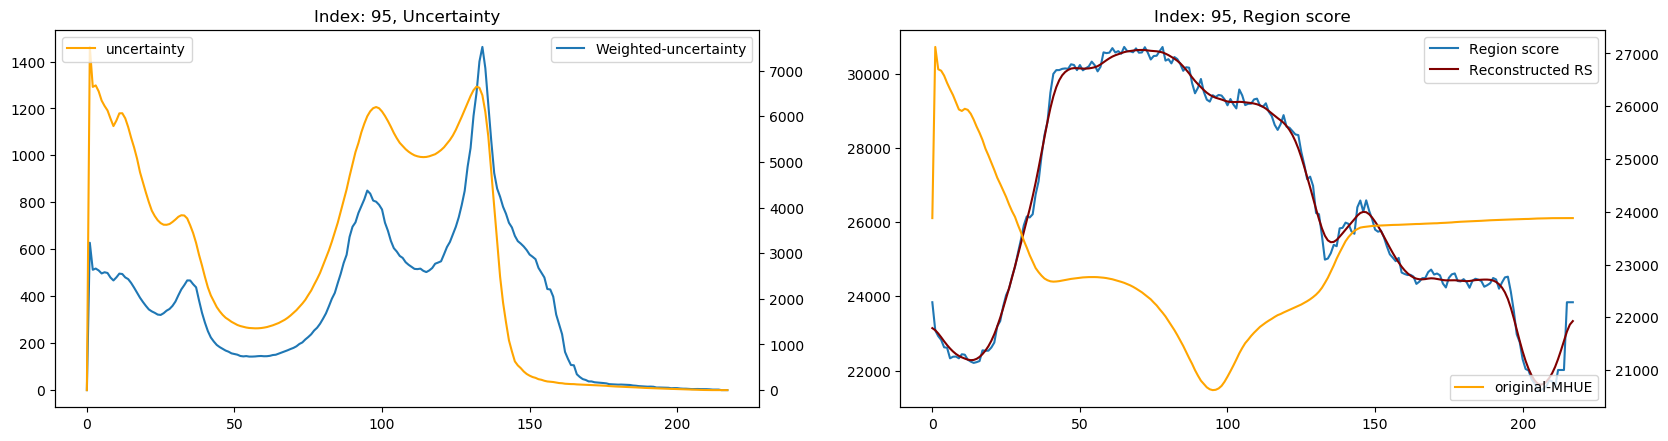

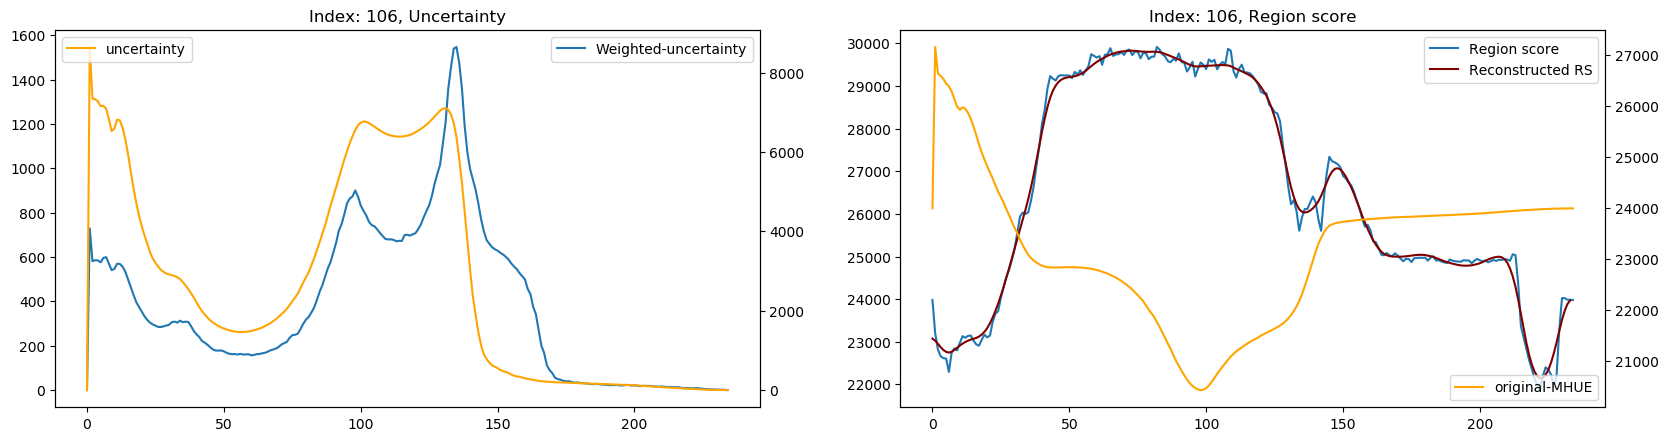

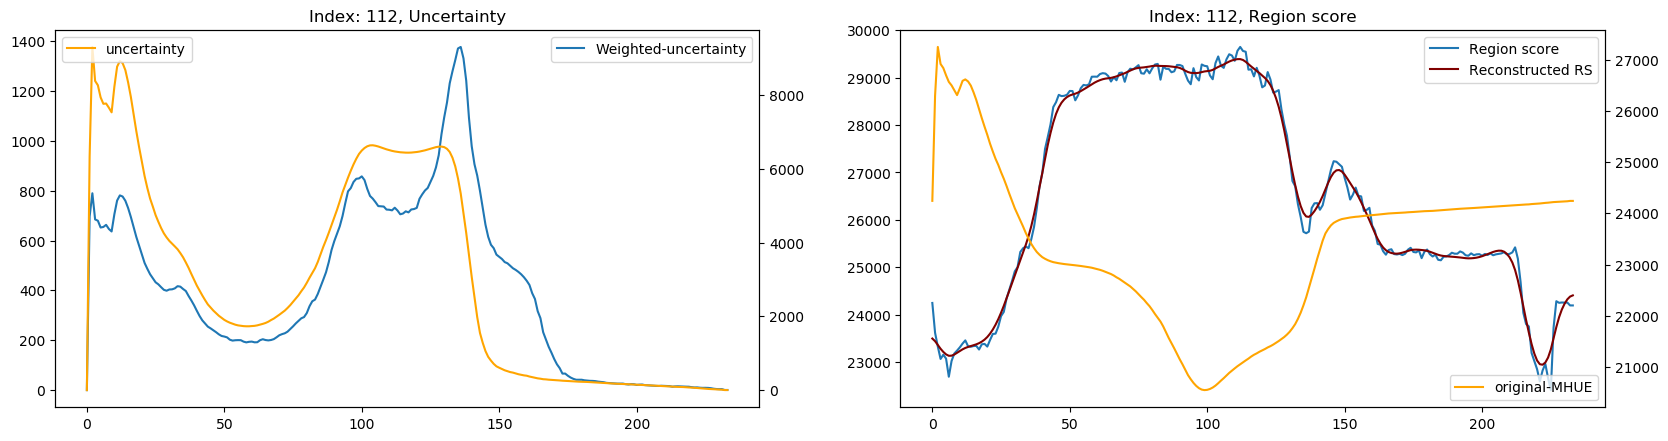

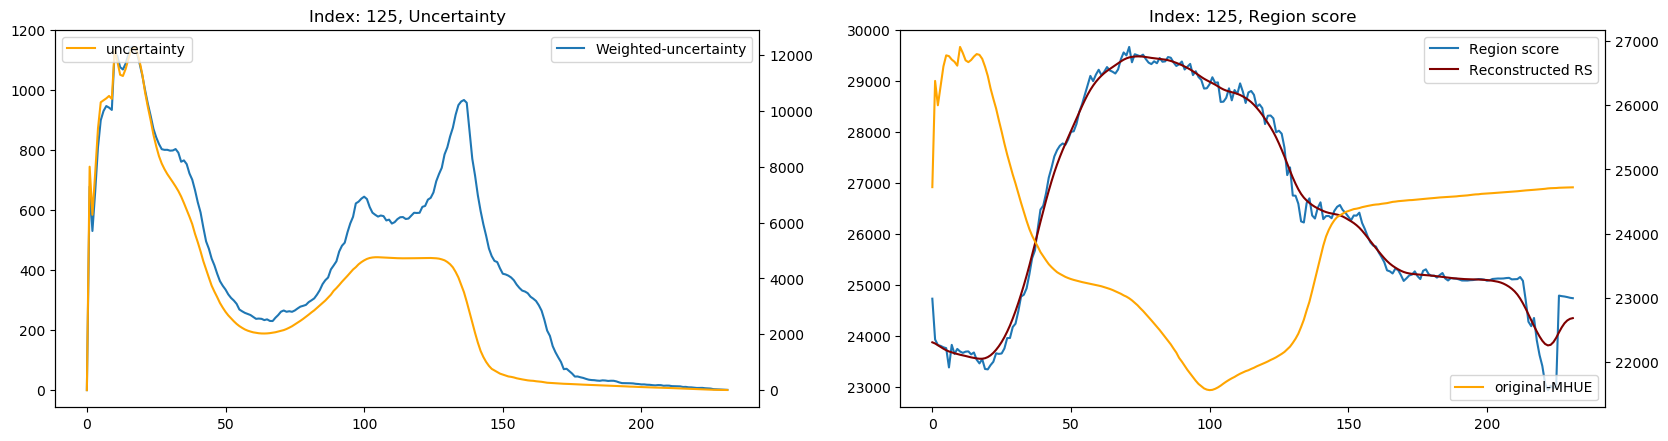

In [16]:
img_idx = param['index']
_uncertainty = param['uncertainty']
_img = param['img']
_stab = param['stab']
_mhue = param['mhue']
_uncertaintyw = param['uncertaintyw']
_region = param['region']
_r_recon = param['r_recon']

for i in range(len(_img)):
    _u = list(map(lambda x:np.sum(x),_uncertainty[i]))
    _uw = list(map(lambda x:np.sum(x),_uncertaintyw[i]))
    _e = list(map(lambda x:np.sum(x),_mhue[i]))
    _r = list(map(lambda x:np.sum(x),_region[i]))
    
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(121)
    ax2 = ax1.twinx()
    ax1.plot(_uw,label='Weighted-uncertainty')
    ax1.legend(loc=1)
    ax2.plot(_u,color='orange',label='uncertainty')
    ax2.legend(loc=2)
    plt.title('Index: {}, Uncertainty'.format(img_idx[i]))
    
    ax3 = fig.add_subplot(122)
    ax4 = ax3.twinx()
    ax3.plot(_r,label='Region score')
    ax3.plot(_r_recon[i],color='maroon',label='Reconstructed RS')
    ax3.legend(loc='upper right')
    ax4.plot(_e,color='orange',label='original-MHUE')
    ax4.legend(loc=4)
    plt.title('Index: {}, Region score'.format(img_idx[i]))
    plt.show()
    plt.close()

In [27]:
# Region score: bounded gradient map & stability weighted uncertainty
def region_score_bounded(param):
    img_idx = param['index']
    img_lst = param['img']
    scharr_b_lst = param['scharr_b']
    stab_lst = param['stab']
    img_bdts_o = param['bdts_o']
    img_bdts_b = param['bdts_b']
    delta_lst = param['delta']
    
    regions = []
    r_recons = []
    region_t = []
    uncertaintyws = []
    for idx,img in enumerate(img_lst):
        uncertaintyw = mhue.get_uncertainty(img, off_center=True, info_w=True, stabs=stab_lst[idx], 
                                            bdts_o=img_bdts_o[idx], bdts_b=img_bdts_b[idx],kernel_size=15,sigma=0.5)
        uncertaintyws.append(uncertaintyw)
        scharr = scharr_b_lst[idx]
        delta = delta_lst[idx]
        region_i = region.get_score(img,uncertaintyw,scharr,kernel_size=5,bounding=True)
        regions.append(region_i)
        r_recon = region.vmd_extract(region_i,var_min=0.01)
        r_recons.append(r_recon)
        # local maxima
        best_region_t = argrelmax(r_recon,order=delta//2)[0] + np.min(img) + 2
        region_t.append(best_region_t)
        print('Index: {}, Region score possible threshold: {}.'.format(img_idx[idx], best_region_t))
    
    param['uncertaintyw'] = uncertaintyws
    param['region'] = regions
    param['r_recon'] = r_recons
    param['region_t'] = region_t
    return param

In [ ]:
# Index: 5, Region score possible threshold: [ 39  87 153].
# Index: 14, Region score possible threshold: [ 39  89 156].
# Index: 21, Region score possible threshold: [ 43  93 135 155].
# Index: 30, Region score possible threshold: [ 45  95 127].
# Index: 47, Region score possible threshold: [ 46 101].
# Index: 60, Region score possible threshold: [59].
# Index: 74, Region score possible threshold: [ 62 103].
# Index: 83, Region score possible threshold: [ 62 106].
# Index: 95, Region score possible threshold: [ 65 108].
# Index: 106, Region score possible threshold: [ 69 107].
# Index: 112, Region score possible threshold: [ 68 110].
# Index: 125, Region score possible threshold: [ 57 109]

In [28]:
param2 = region_score_bounded(param)

Index: 5, Region score possible threshold: [ 39  87 153].
Index: 14, Region score possible threshold: [ 39  89 156].
Index: 21, Region score possible threshold: [ 43  93 134 155].
Index: 30, Region score possible threshold: [ 45  95 127].
Index: 47, Region score possible threshold: [ 46 101].
Index: 60, Region score possible threshold: [58].
Index: 74, Region score possible threshold: [ 63 103].
Index: 83, Region score possible threshold: [ 62 106].
Index: 95, Region score possible threshold: [ 65 108].
Index: 106, Region score possible threshold: [ 70 108].
Index: 112, Region score possible threshold: [ 68 110].
Index: 125, Region score possible threshold: [ 57 108].


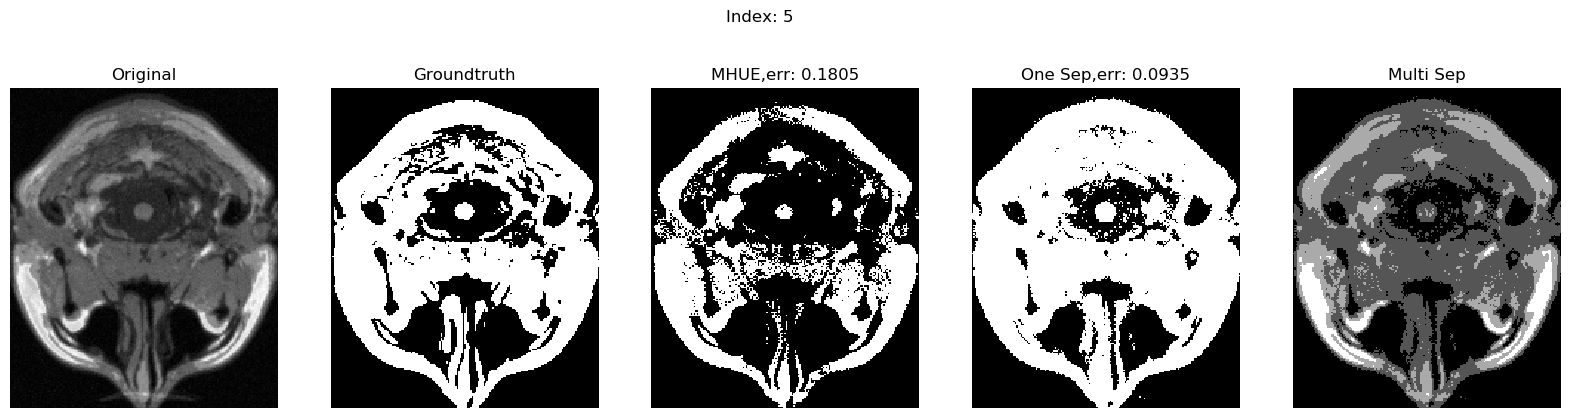

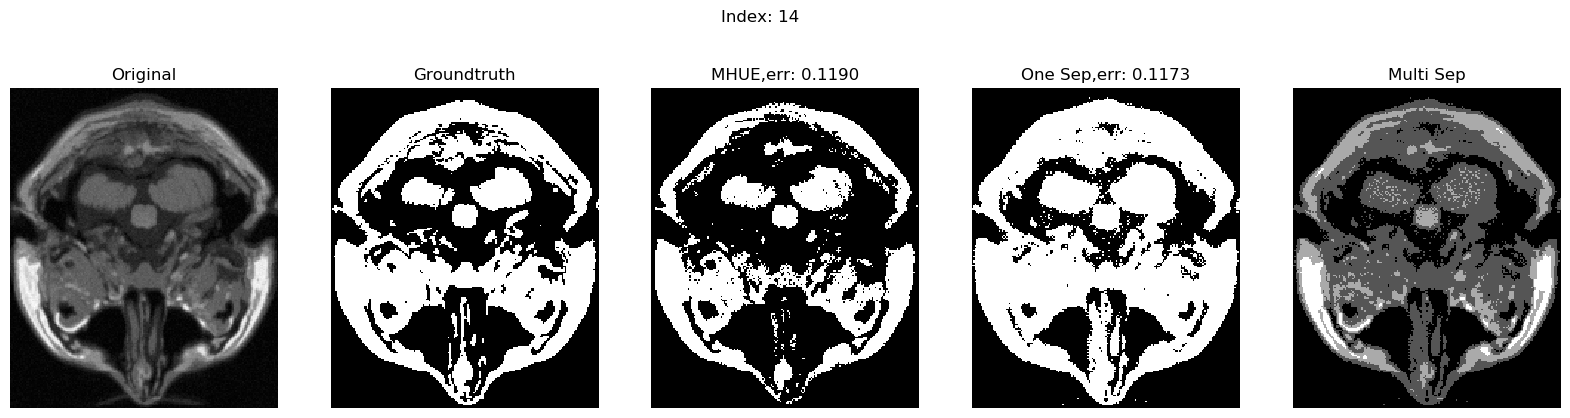

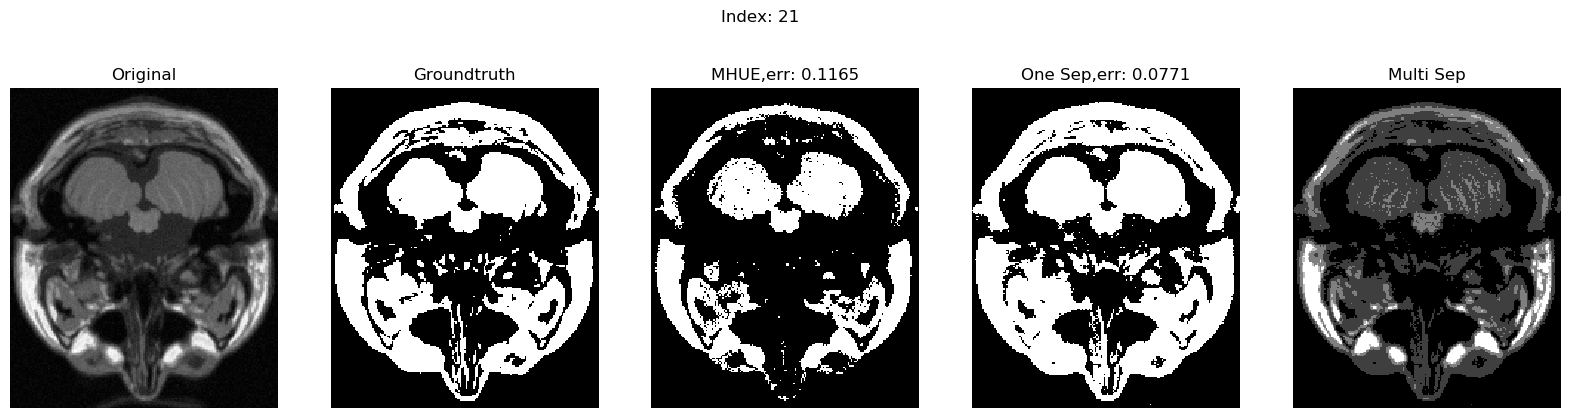

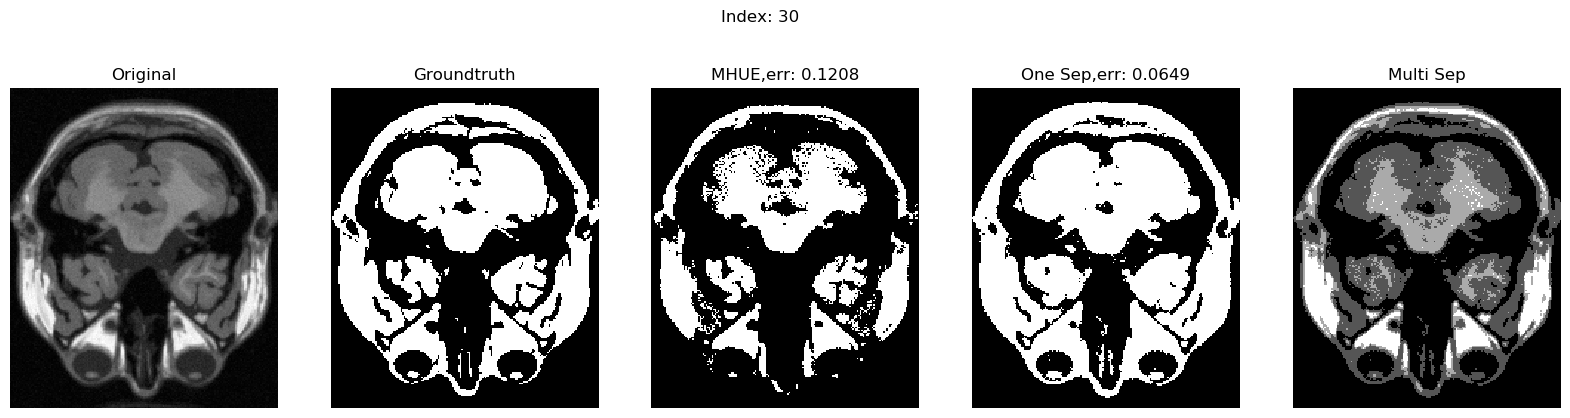

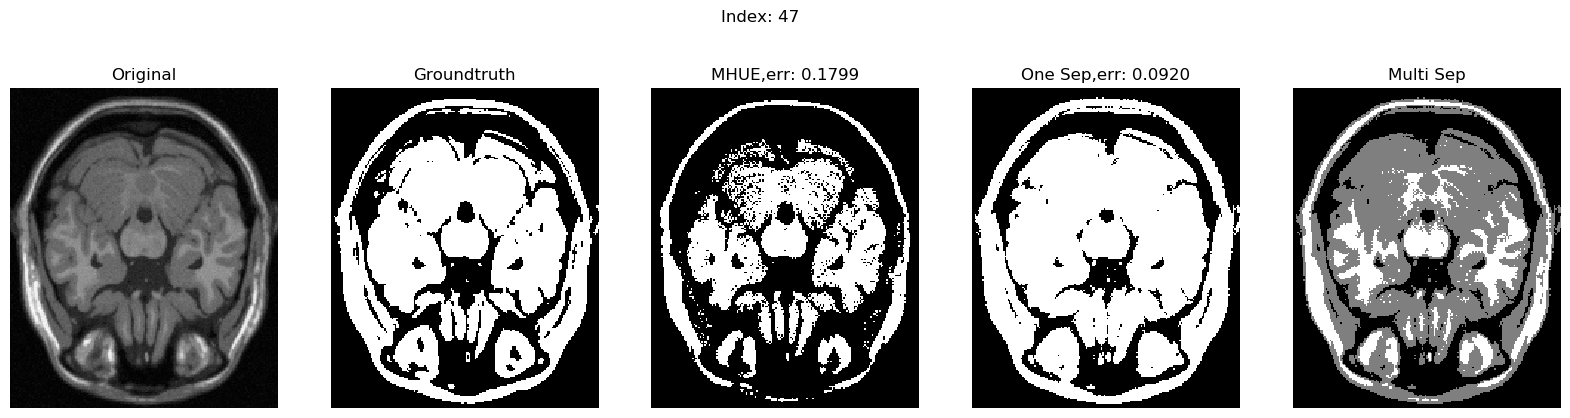

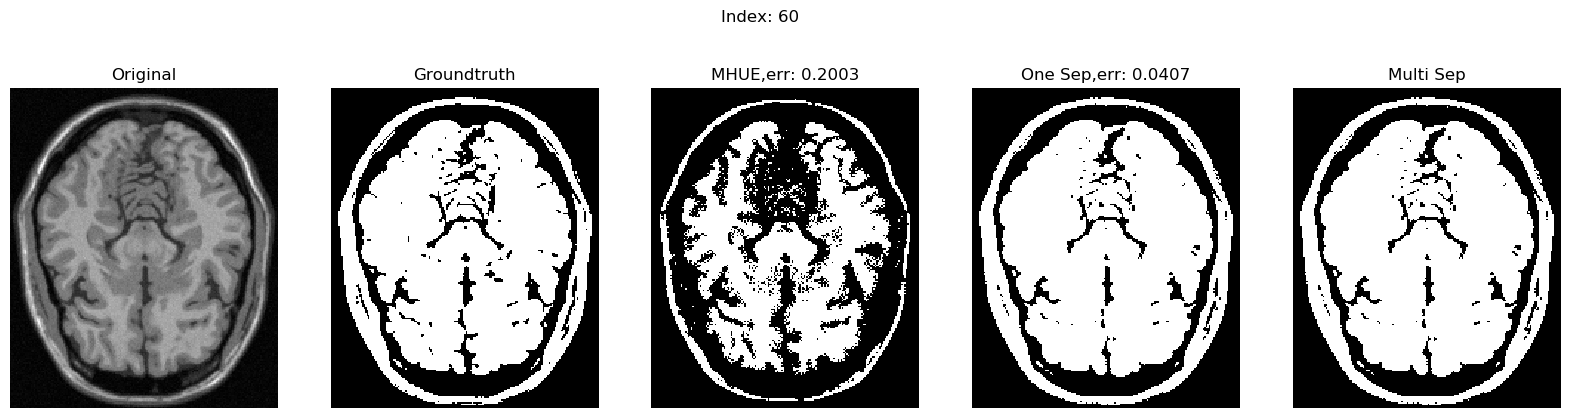

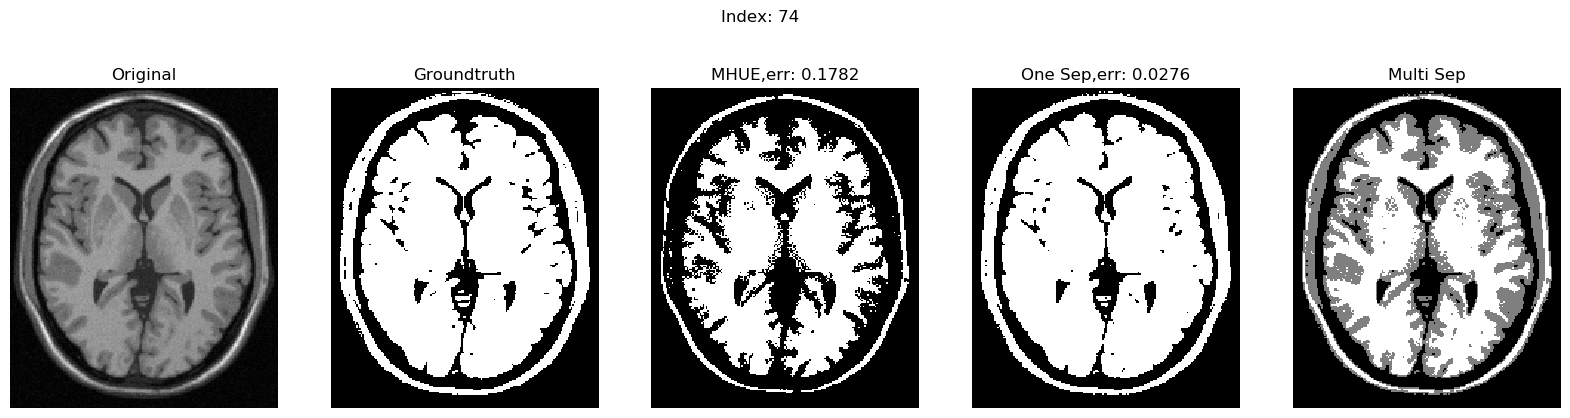

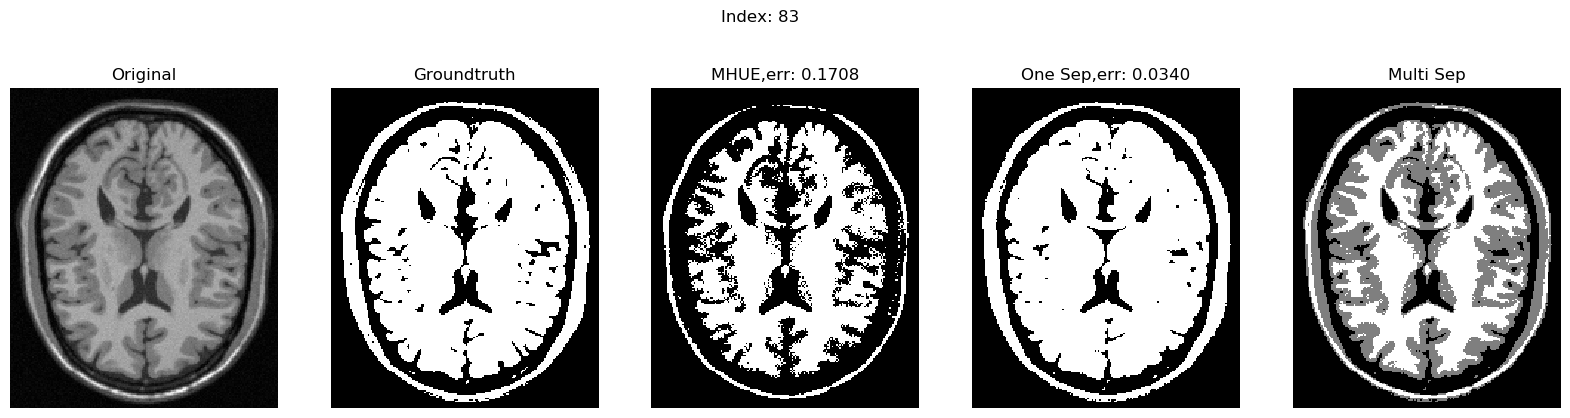

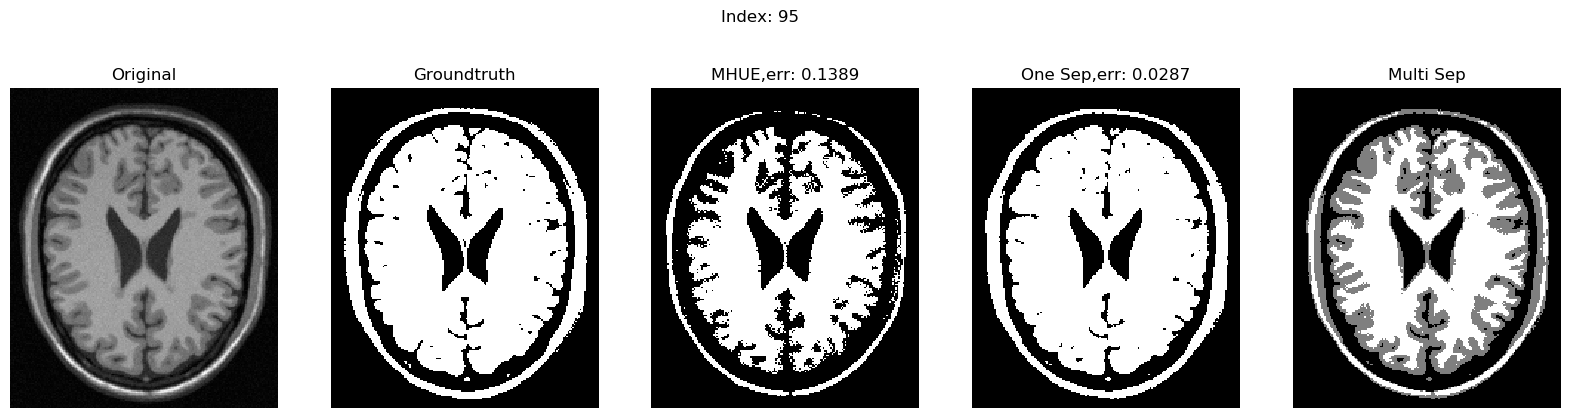

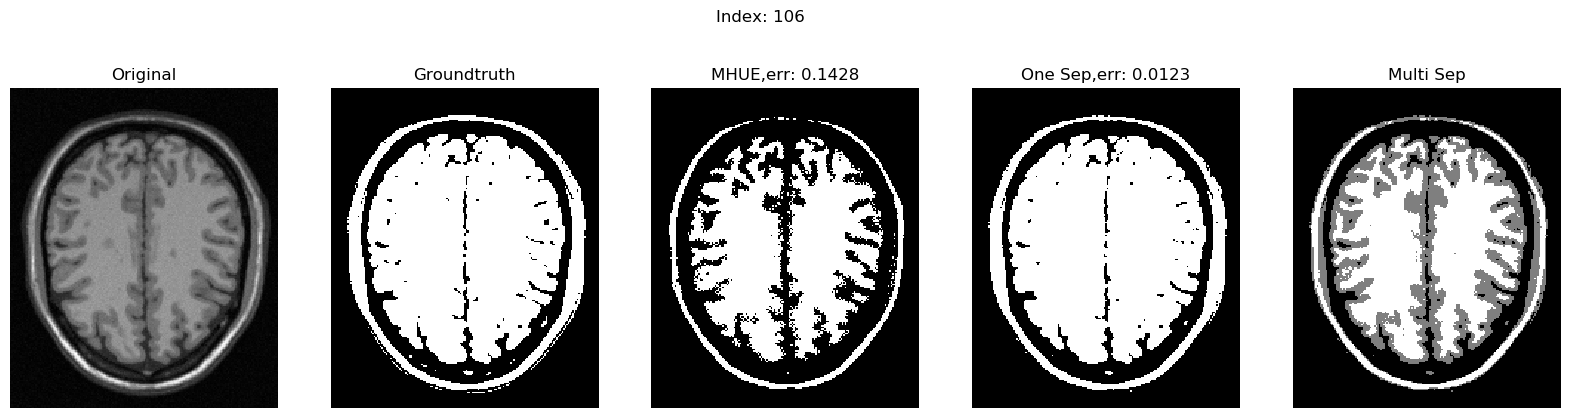

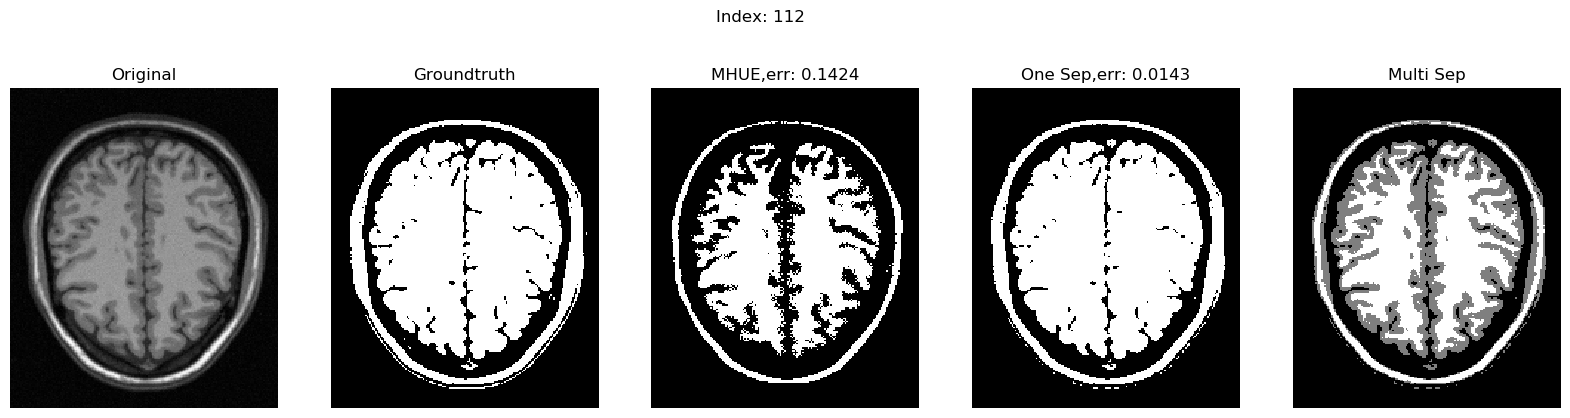

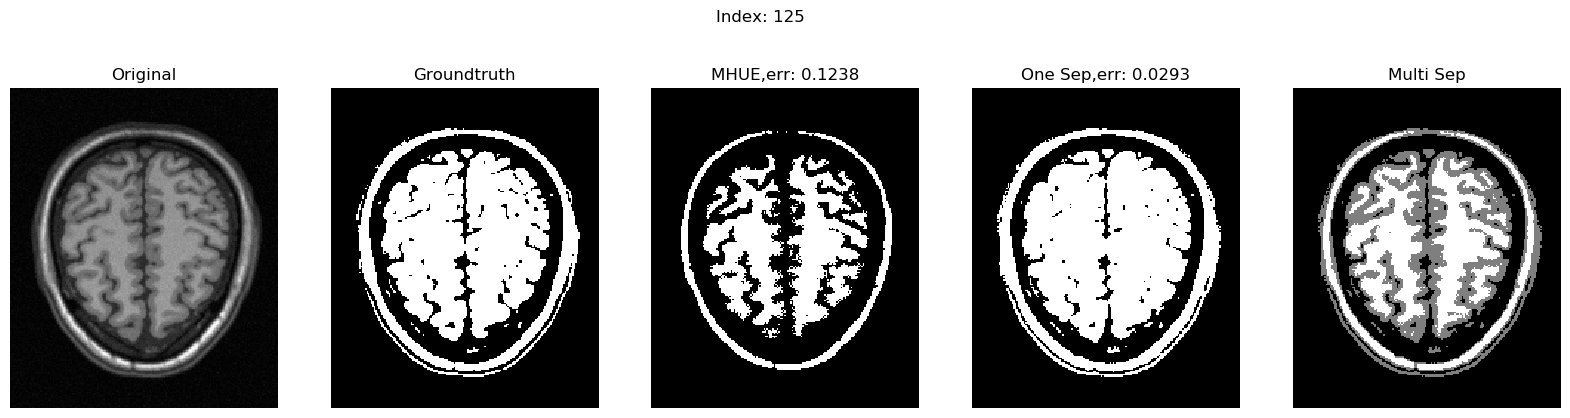

In [29]:
img_idx = param2['index']
img_lst = param2['img_org']
mhue_t = param2['mhue_t']
region_t = param2['region_t']
gt_lst = param2['gt']

for idx,img in enumerate(img_lst):
    region_maxt = region_t[idx]
    mhue_mint = mhue_t[idx]
    gt = gt_lst[idx]
    plt.figure(figsize=(20,5))
    plt.suptitle('Index: {}'.format(img_idx[idx]))
    plt.subplot(151)
    plt.axis('off')
    plt.title('Original')
    plt.imshow(img,cmap='gray')
    plt.subplot(152)
    plt.axis('off')
    plt.title('Groundtruth')
    plt.imshow(gt,cmap='gray')
    
    plt.subplot(153)
    plt.axis('off')
    _,tmp = cv.threshold(img,mhue_mint,255,0)
    err = match_groundtruth.get_error_rate(tmp,gt)
    plt.title('MHUE,err: {:.4f}'.format(err))
    plt.imshow(tmp,cmap='gray')
    
    n_sep = region_maxt.size
    sep = np.zeros(shape=img.shape) * 255
    for n in range(n_sep):
        _,tmp = cv.threshold(img,region_maxt[n],255,0)
        if n==0:
            plt.subplot(154)
            err = match_groundtruth.get_error_rate(tmp,gt)
            plt.axis('off')
            plt.title('One Sep,err: {:.4f}'.format(err))
            plt.imshow(tmp,cmap='gray')
        sep[np.where(tmp==255)] = int(255*(n+1)/n_sep)
    plt.subplot(155)
    plt.axis('off')
    plt.title('Multi Sep')
    plt.imshow(sep,cmap='gray')

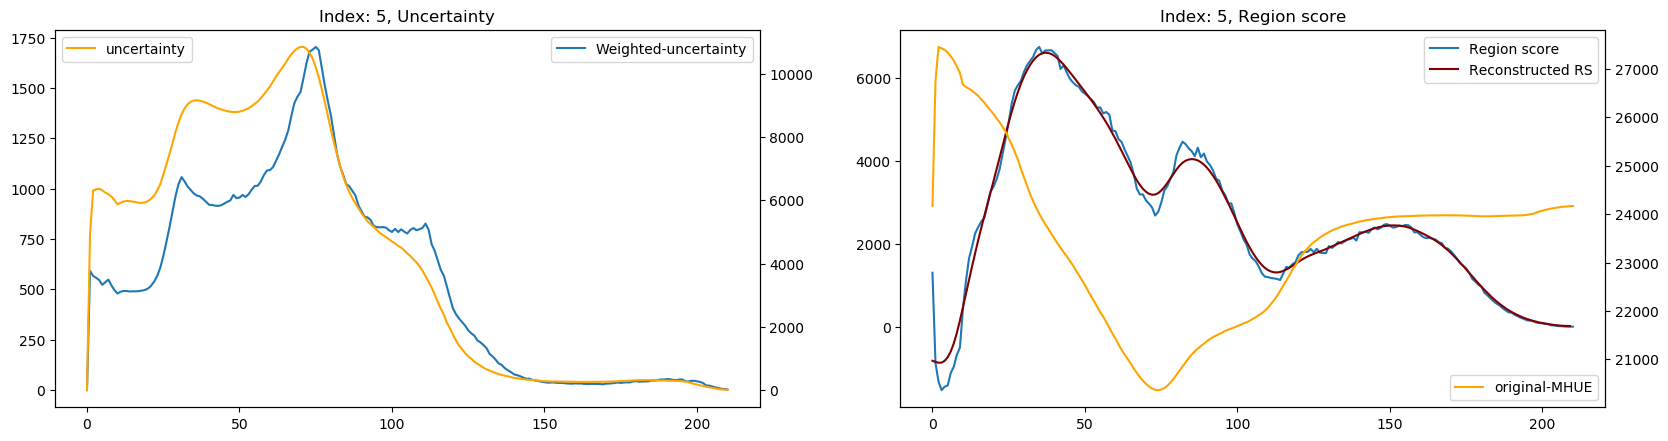

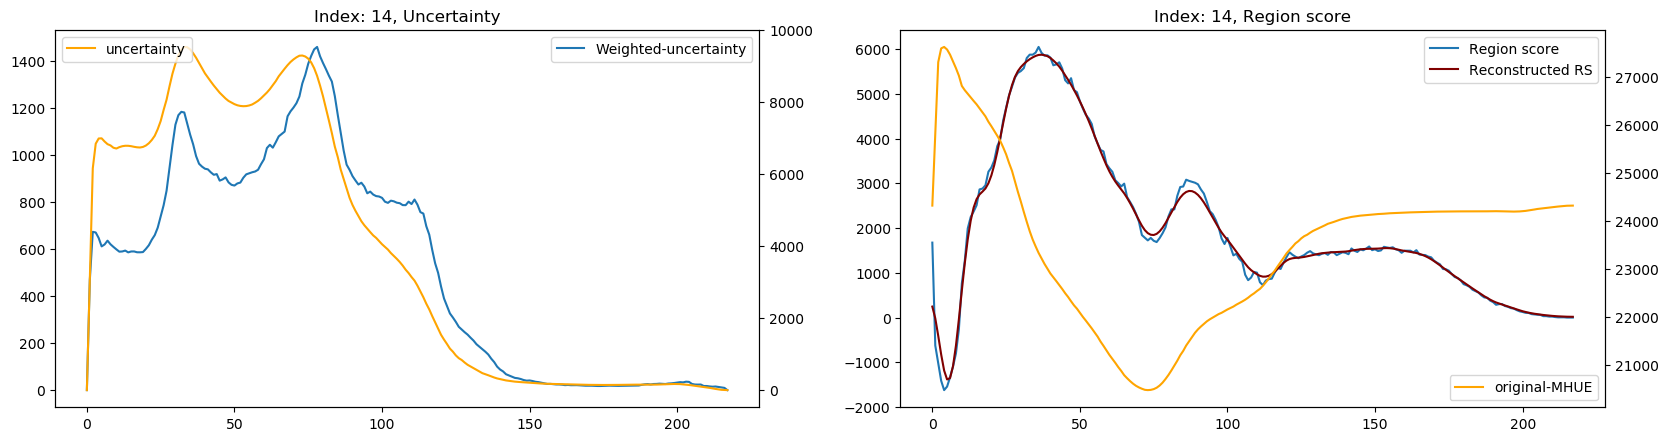

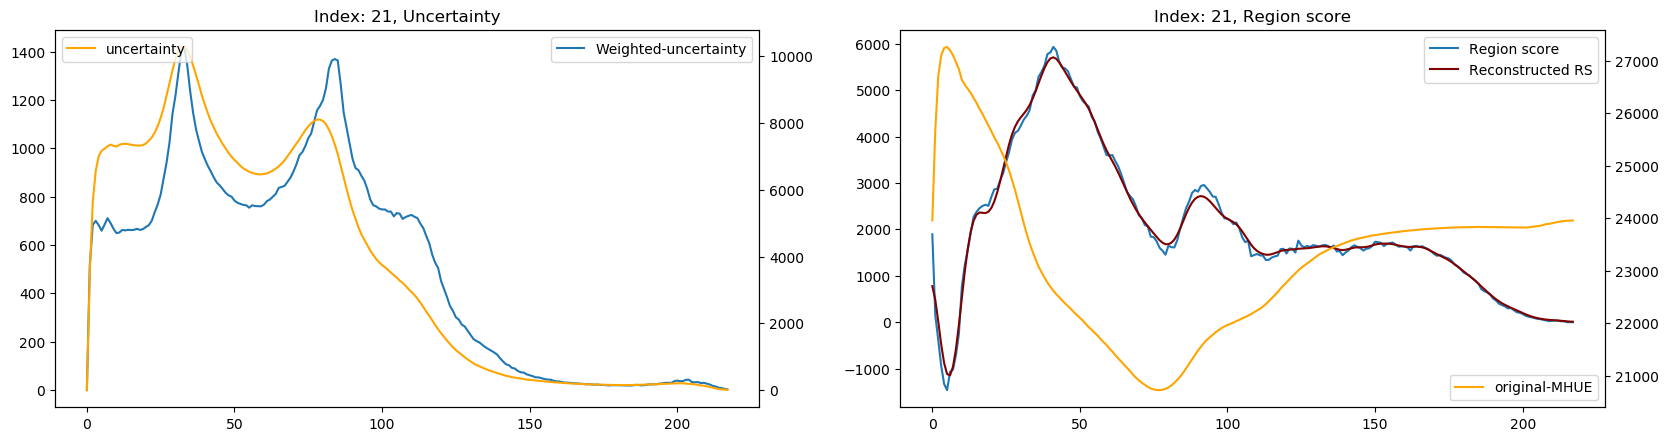

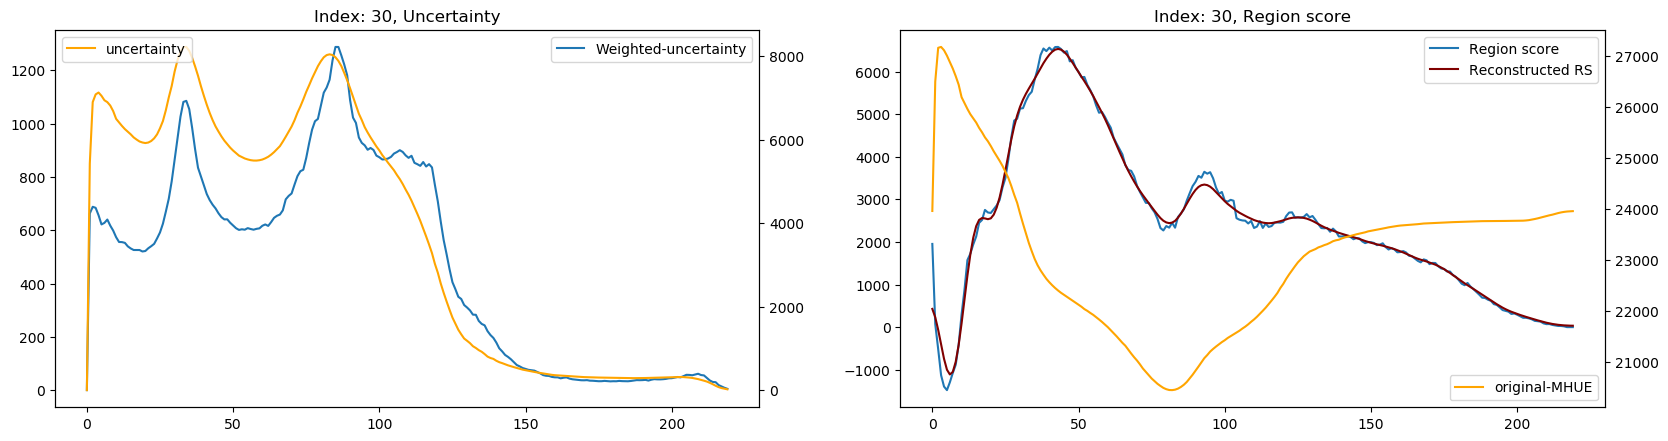

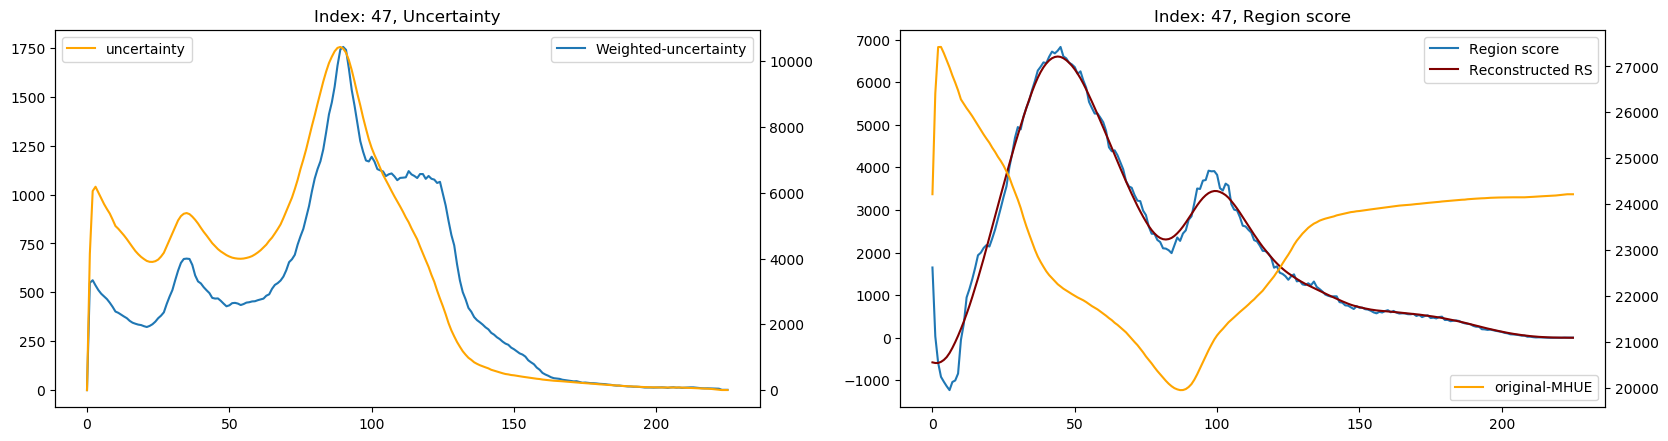

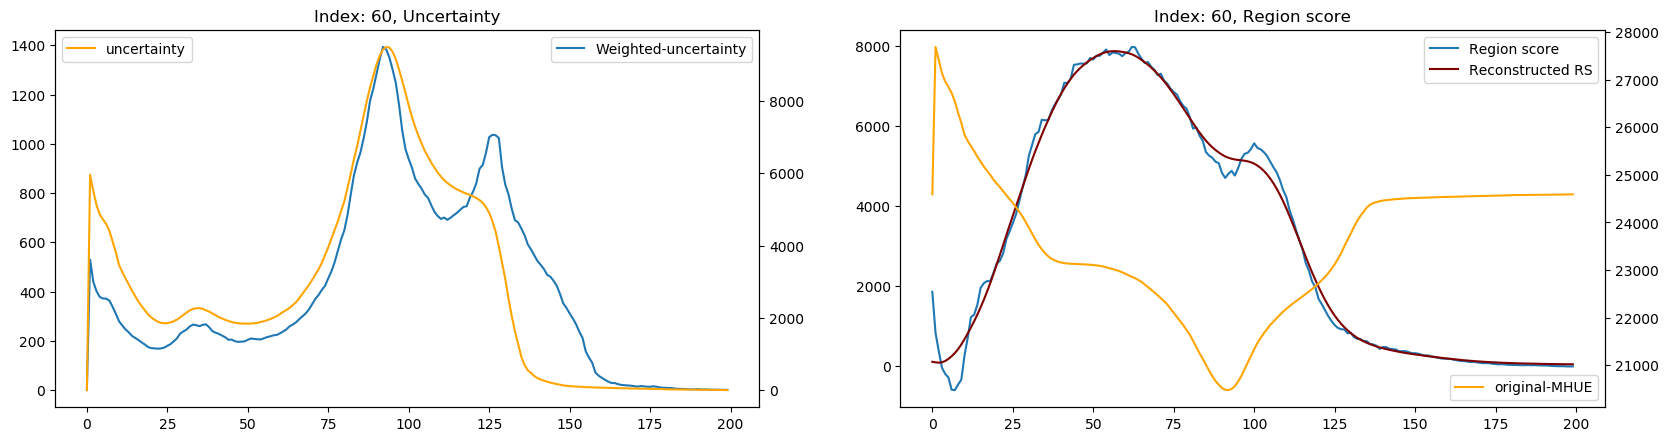

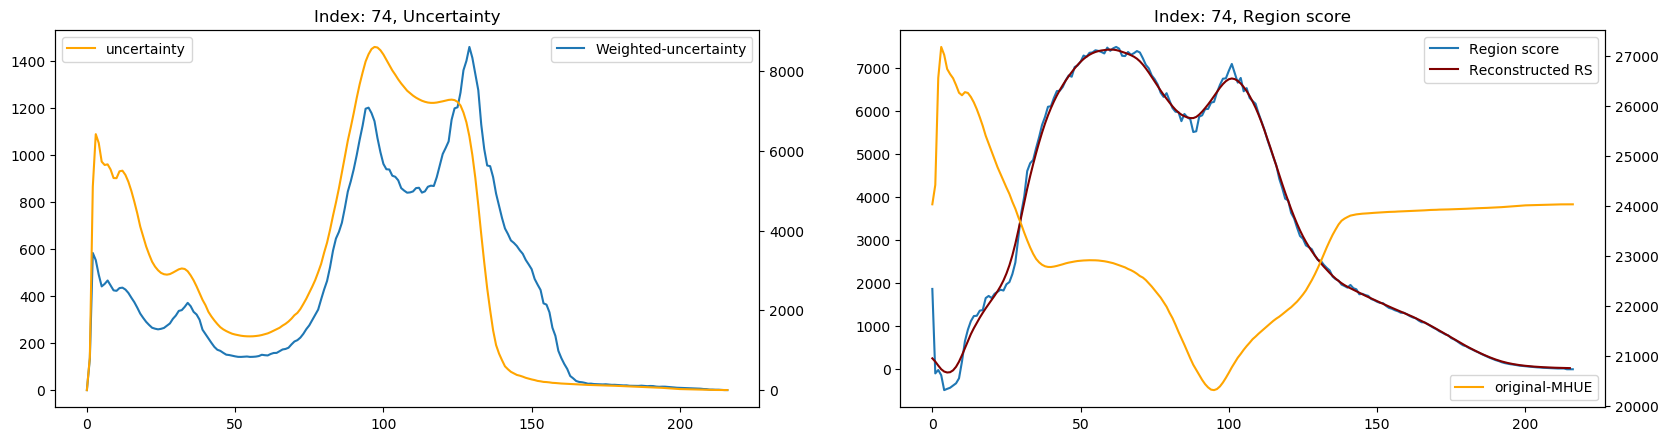

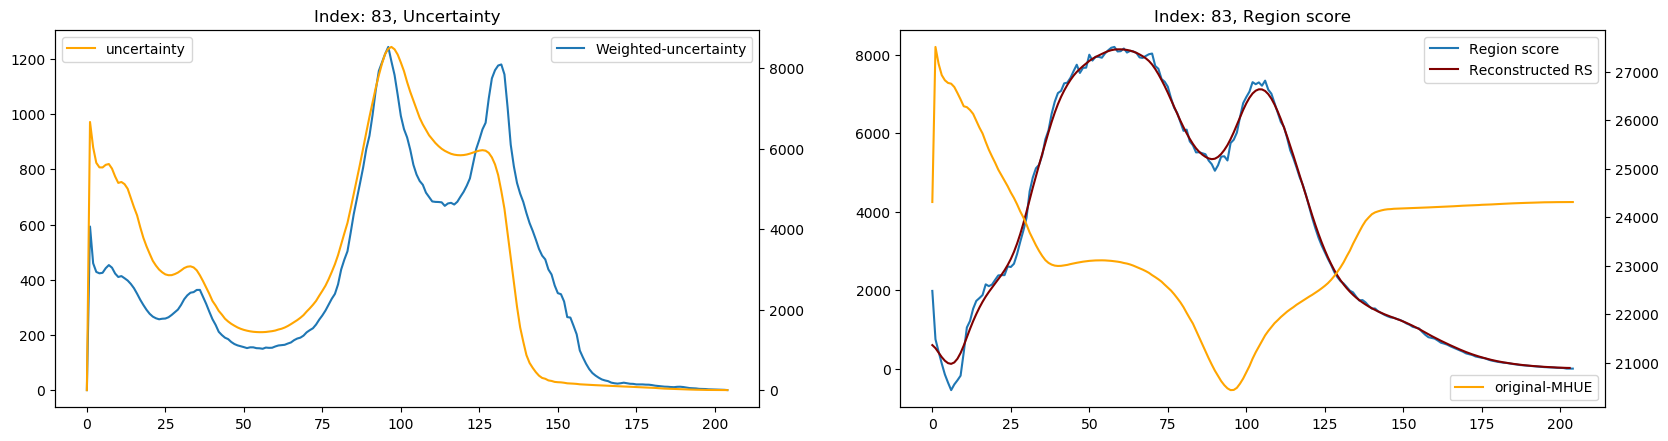

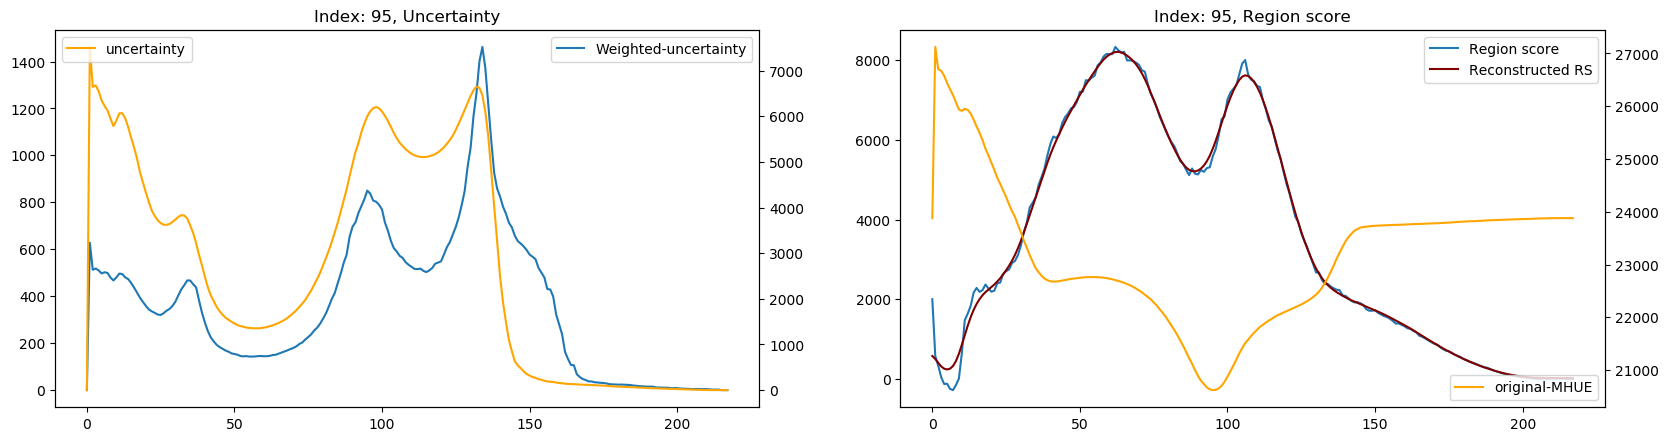

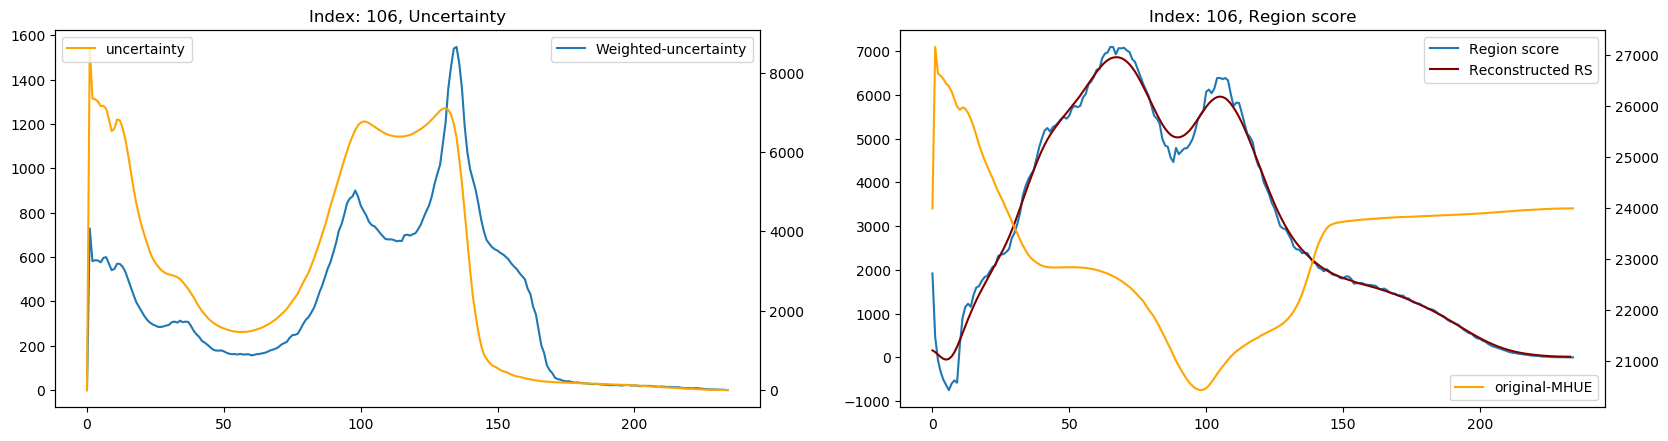

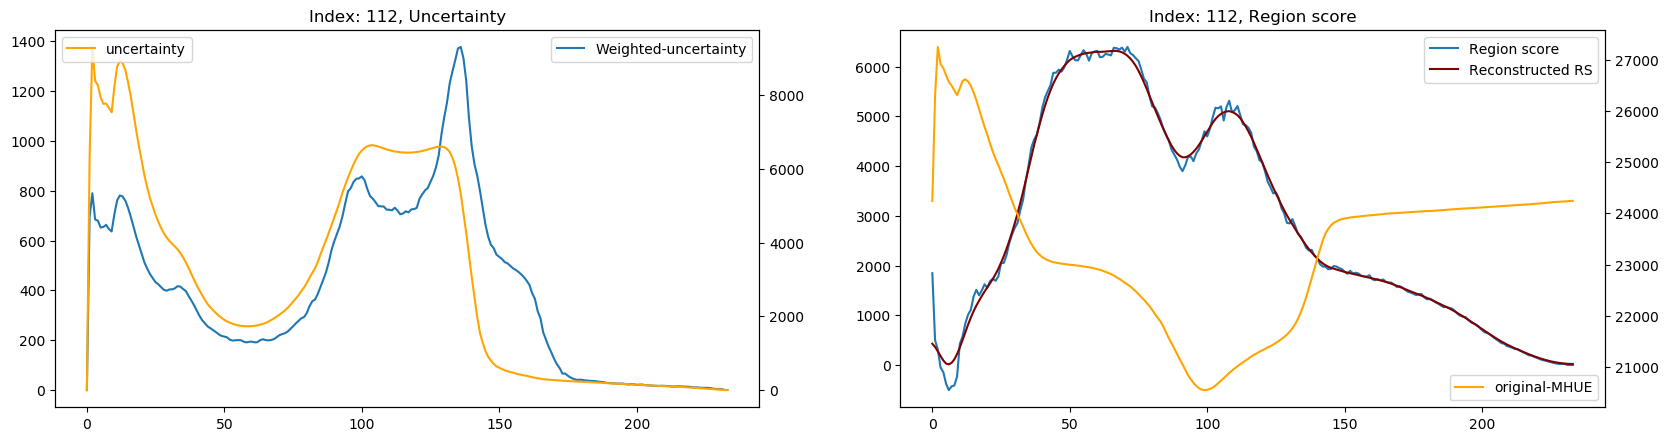

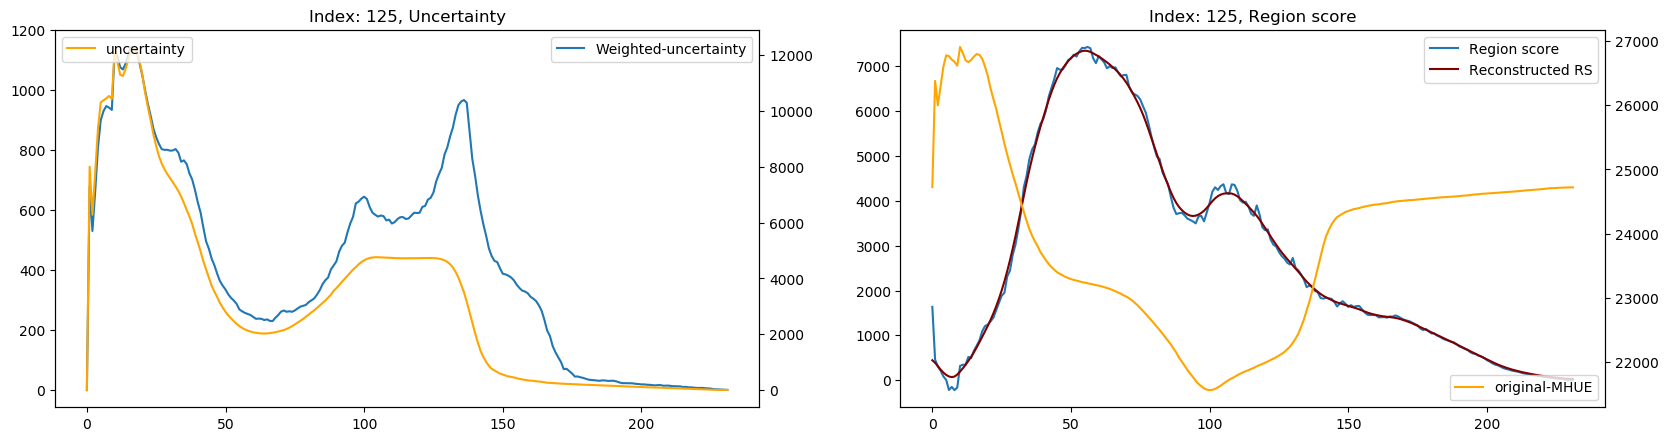

In [23]:
_uncertainty = param2['uncertainty']
_img = param2['img']
_stab = param2['stab']
_mhue = param2['mhue']
_uncertaintyw = param2['uncertaintyw']
_region = param2['region']
_r_recon = param2['r_recon']
img_idx = param2['index']

for i in range(len(_img)):
    _u = list(map(lambda x:np.sum(x),_uncertainty[i]))
    _uw = list(map(lambda x:np.sum(x),_uncertaintyw[i]))
    _e = list(map(lambda x:np.sum(x),_mhue[i]))
    _r = list(map(lambda x:np.sum(x),_region[i]))
    
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(121)
    ax2 = ax1.twinx()
    ax1.plot(_uw,label='Weighted-uncertainty')
    ax1.legend(loc=1)
    ax2.plot(_u,color='orange',label='uncertainty')
    ax2.legend(loc=2)
    plt.title('Index: {}, Uncertainty'.format(img_idx[i]))
    
    ax3 = fig.add_subplot(122)
    ax4 = ax3.twinx()
    ax3.plot(_r,label='Region score')
    ax3.plot(_r_recon[i],color='maroon',label='Reconstructed RS')
    ax3.legend(loc='upper right')
    ax4.plot(_e,color='orange',label='original-MHUE')
    ax4.legend(loc=4)
    plt.title('Index: {}, Region score'.format(img_idx[i]))
    plt.show()
    plt.close()

In [24]:
def region_multi(param,n_sep=3):
    img_idx = param['index']
    img_lst = param['img']
    scharr_b_lst = param['scharr_b']
    stab_lst = param['stab']
    img_bdts_o = param['bdts_o']
    img_bdts_b = param['bdts_b']
    delta_lst = param['delta']
    
    region_t = []
    for idx,img in enumerate(img_lst):
        ts = []
        # mark the next minima
        next_minima = 0
        delta = delta_lst[idx]
        scharr = scharr_b_lst[idx]
        mask = np.ones(img.shape).astype(np.uint8)
        
#         uncertaintyw = mhue.get_uncertainty(img, off_center=True, info_w=True, stabs=stab_lst[idx], 
#                                             bdts_o=img_bdts_o[idx], bdts_b=img_bdts_b[idx],kernel_size=31,sigma=0.5)
#         uncertaintyws.append(uncertaintyw)
#         scharr = scharr_b_lst[idx]
#         delta = delta_lst[idx]
#         region_i = region.get_score(img,uncertaintyw,scharr,kernel_size=5,bounding=True)
#         regions.append(region_i)
#         r_recon = region.vmd_extract(region_i,var_min=0.01)
#         r_recons.append(r_recon)
#         # local maxima
#         best_region_t = argrelmax(r_recon,order=delta//2)[0] + np.min(img) + 2
#         region_t.append(best_region_t)
#         print('Index: {}, Region score possible threshold: {}.'.format(img_idx[idx], best_region_t))
        
        for sep in range(n_sep):
            img_mask = img * mask
            uncertaintyw = mhue.get_uncertainty(img_mask, off_center=True, info_w=True, stabs=stab_lst[idx], 
                                                bdts_o=img_bdts_o[idx], bdts_b=img_bdts_b[idx],kernel_size=31,sigma=0.5)
            # new region score
            region_i = region.get_score(img_mask,uncertaintyw,scharr,kernel_size=5,bounding=True)
            r_recon = region.vmd_extract(region_i,var_min=0.01)
            # some weired case
            if len(r_recon) <= 1:
                break
            # very first maxima
            local_max = argrelmax(r_recon,order=delta//2)[0]
            
            # take the local maxima if it's larger than the former valley value
            flag = False
            if len(local_max) >= 1:
                for t in local_max:
                    if t > next_minima:
                        local_max = t
                        flag = True
                        break
            # jump out if not maxima is found
            elif len(local_max) == 0:
                break
            
            # jump out if the maxima is smaller than the former valley value
            if not flag:
                break
            
            best_region_t = local_max + np.min(img) + 2
            ts.append(best_region_t)
            _,mask = cv.threshold(img,best_region_t,1,0)
            
            # find the next minima
            local_min = argrelmin(r_recon,order=delta//2)[0]  + np.min(img) + 2
            
            # Find the next valley value larger the current best region t
            if np.max(local_min) < local_max:
                break
            else:
                for t in local_min:
                    if t > local_max:
                        next_minima = t
                        break

        print('Index: {}, Region score threshold: {}.'.format(img_idx[idx], ts))
        region_t.append(ts)
    param['region_multi_t'] = region_t
    return param

In [25]:
param2 = region_multi(param)

Index: 5, Region score threshold: [39, 84, 148].
Index: 14, Region score threshold: [39, 149].
Index: 21, Region score threshold: [43, 93, 126].
Index: 30, Region score threshold: [45, 131].
Index: 47, Region score threshold: [46, 132].
Index: 60, Region score threshold: [59].
Index: 74, Region score threshold: [62, 114].
Index: 83, Region score threshold: [62, 112].
Index: 95, Region score threshold: [65, 114].
Index: 106, Region score threshold: [69, 128, 199].
Index: 112, Region score threshold: [68, 132, 200].
Index: 125, Region score threshold: [57, 111].


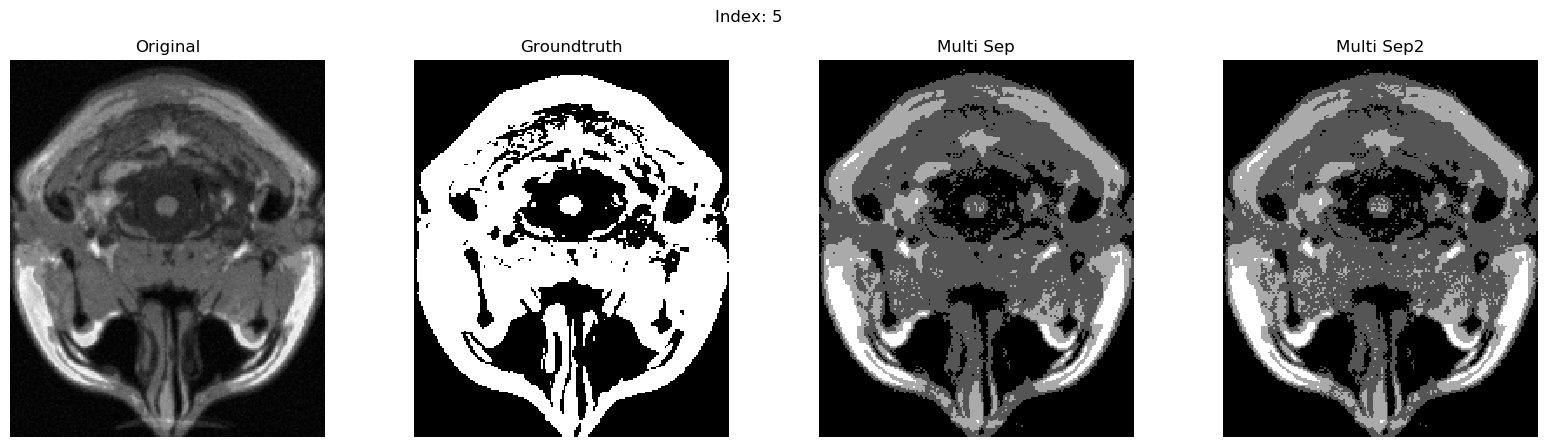

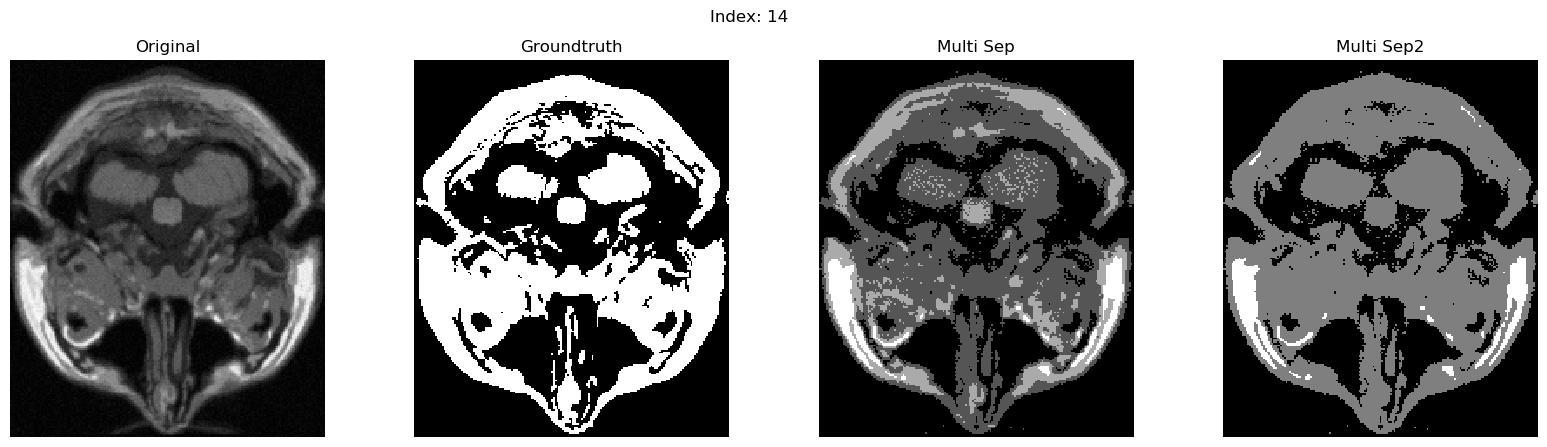

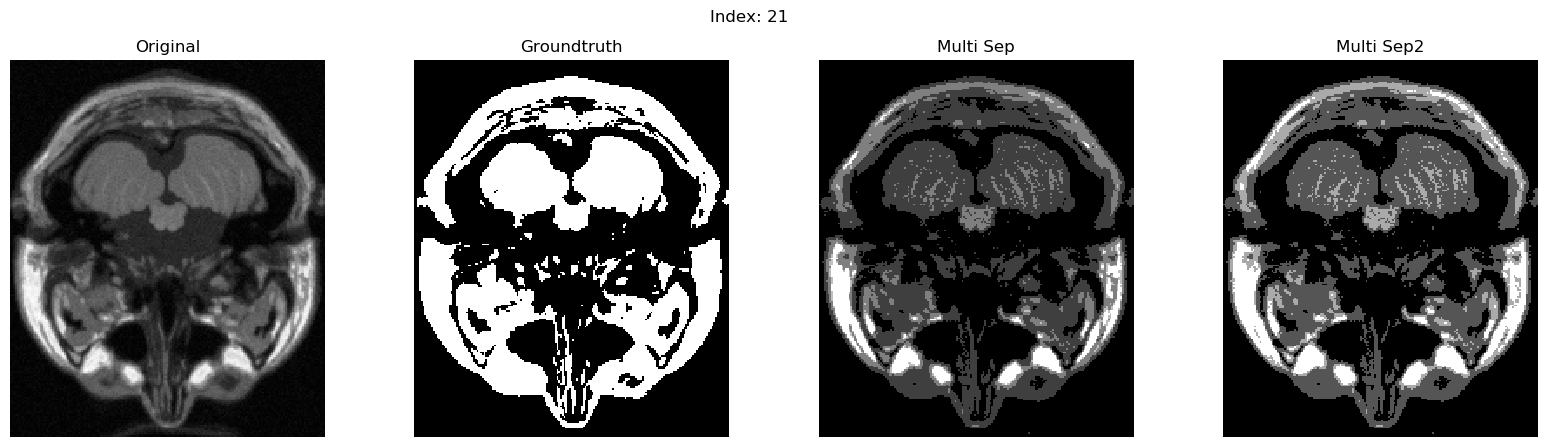

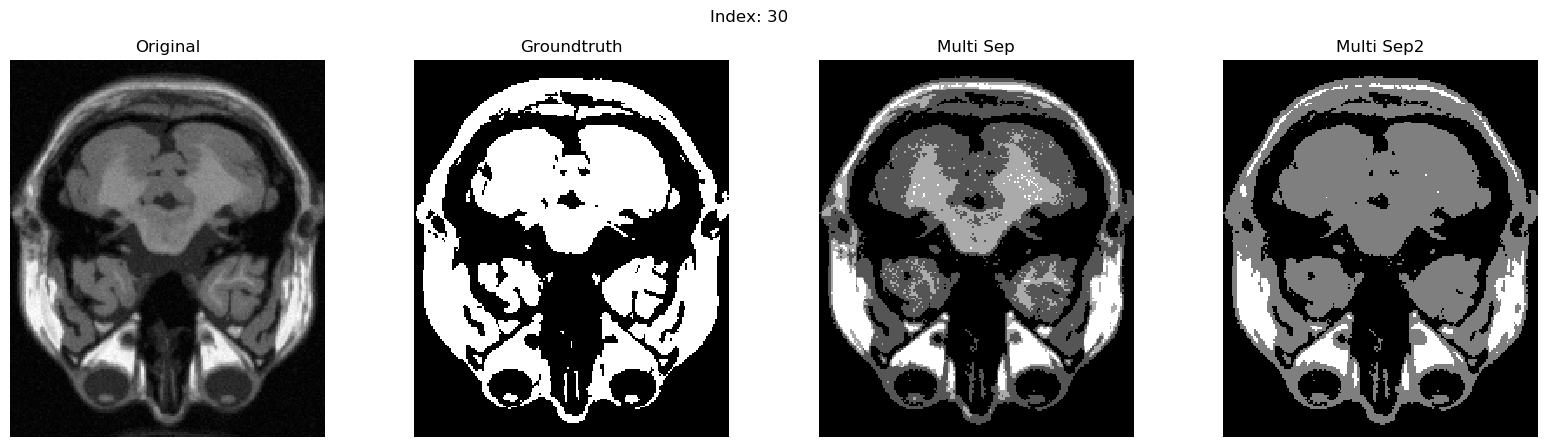

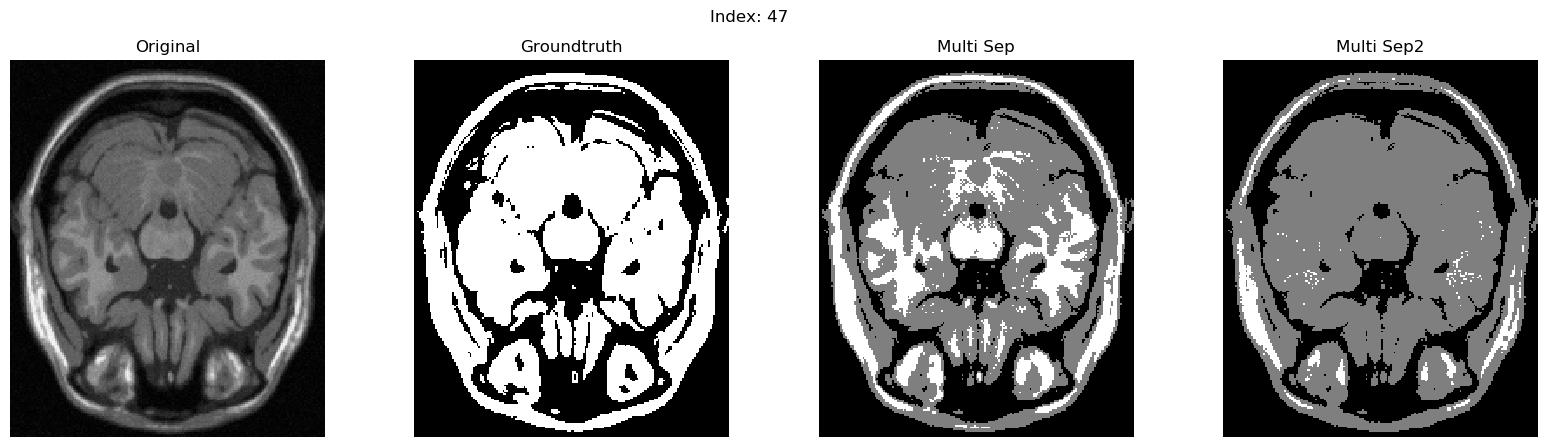

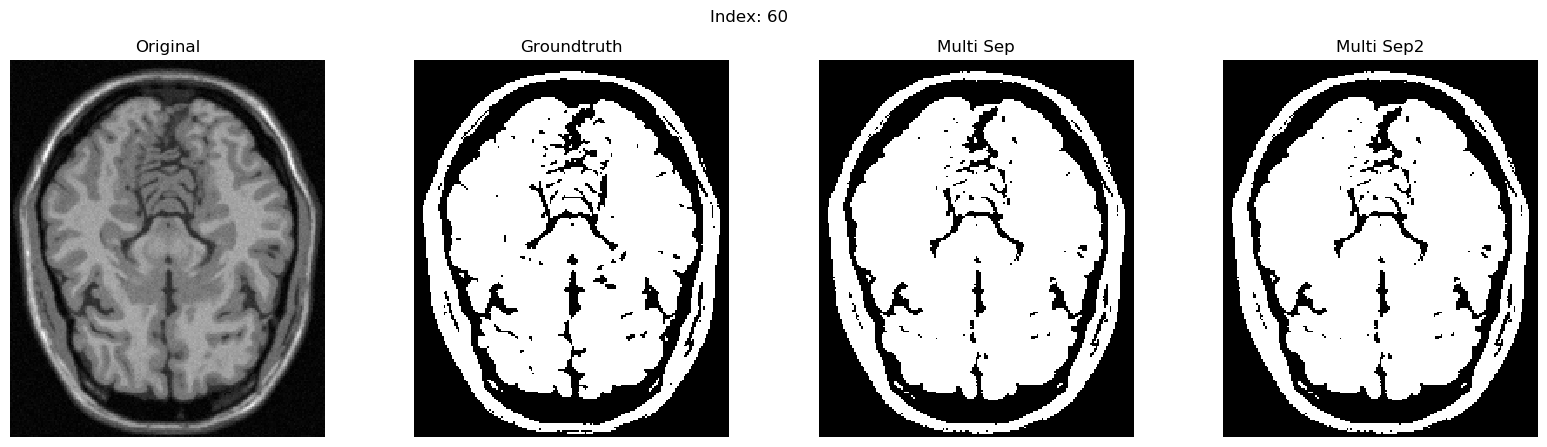

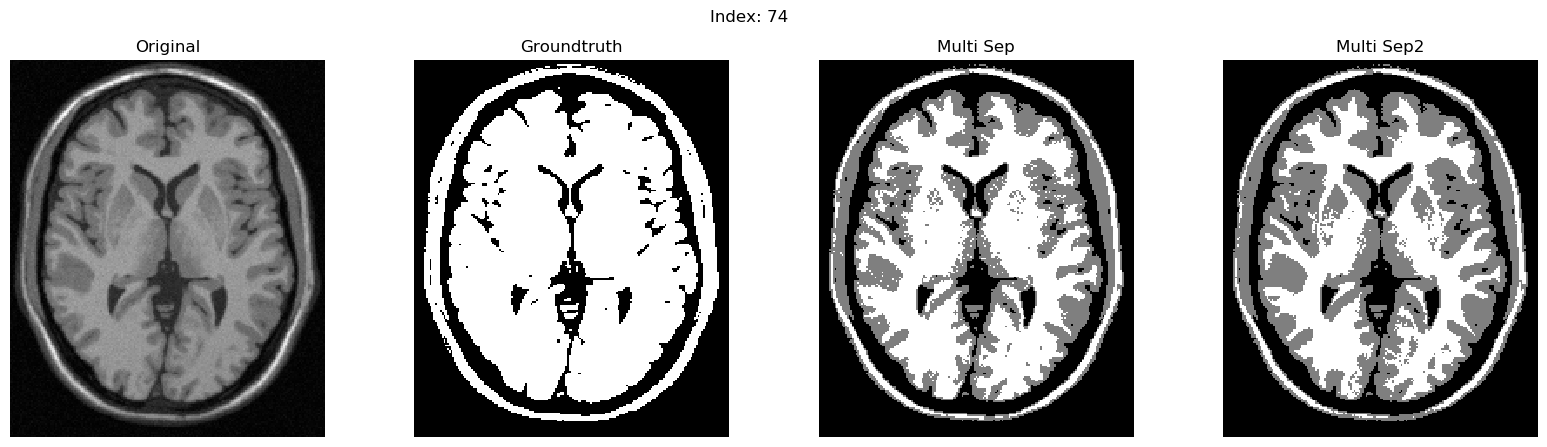

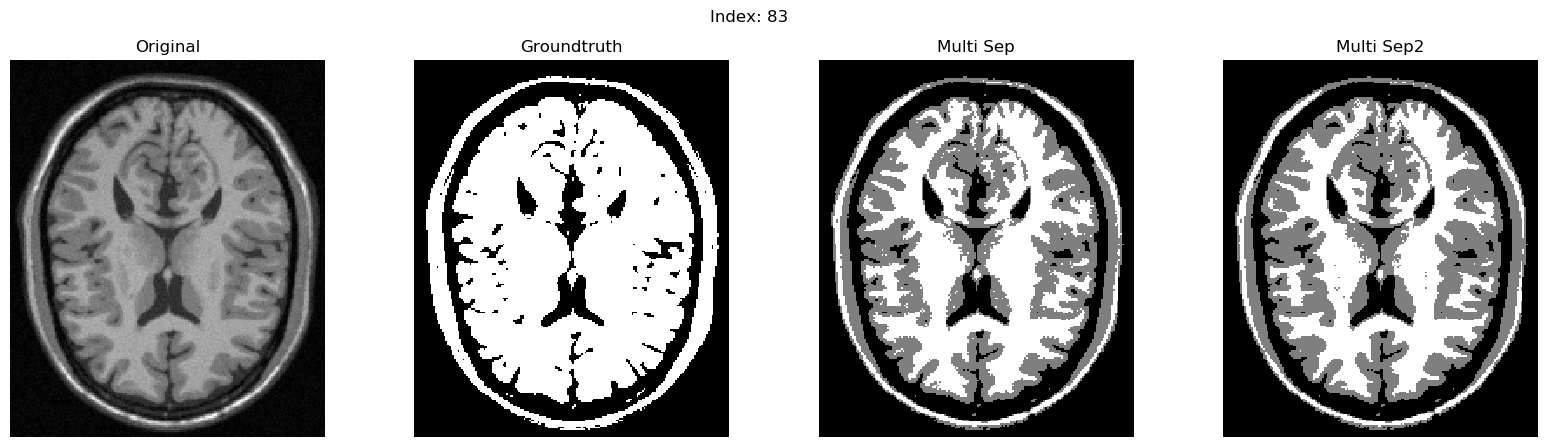

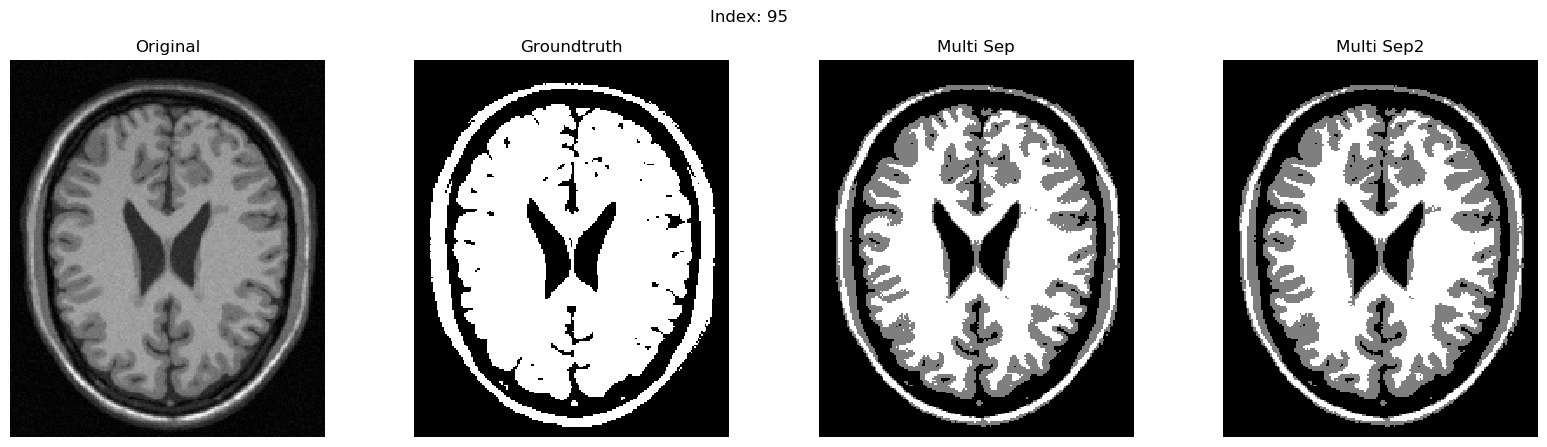

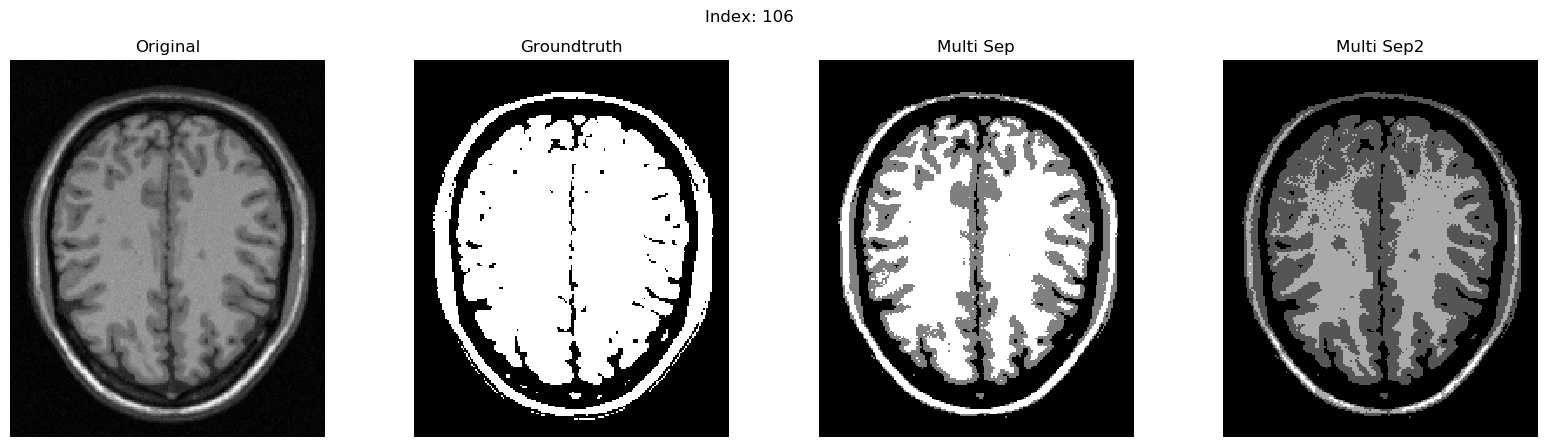

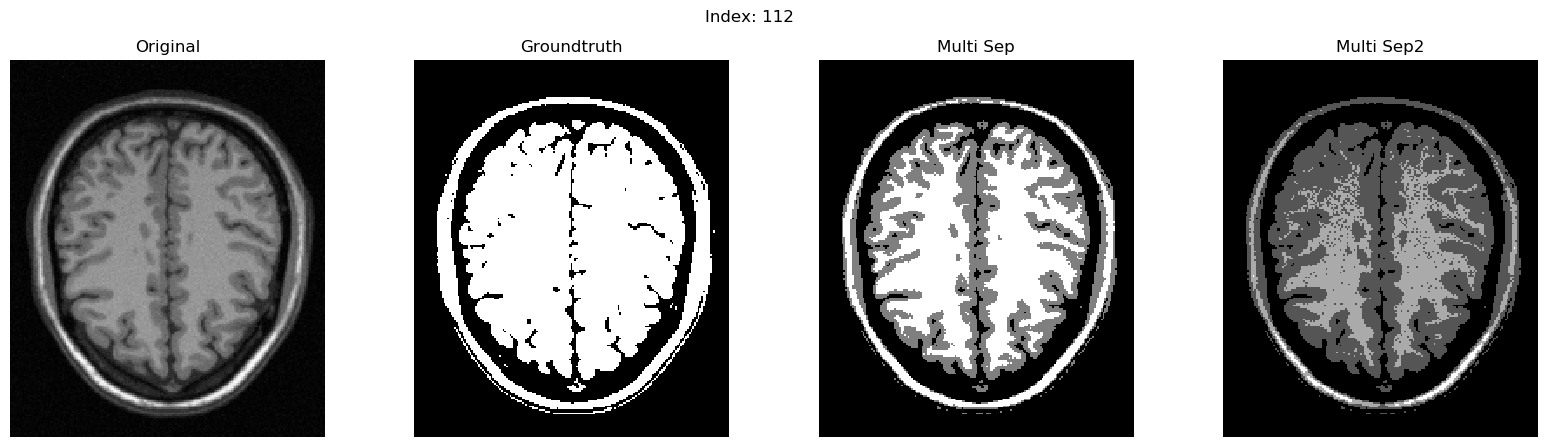

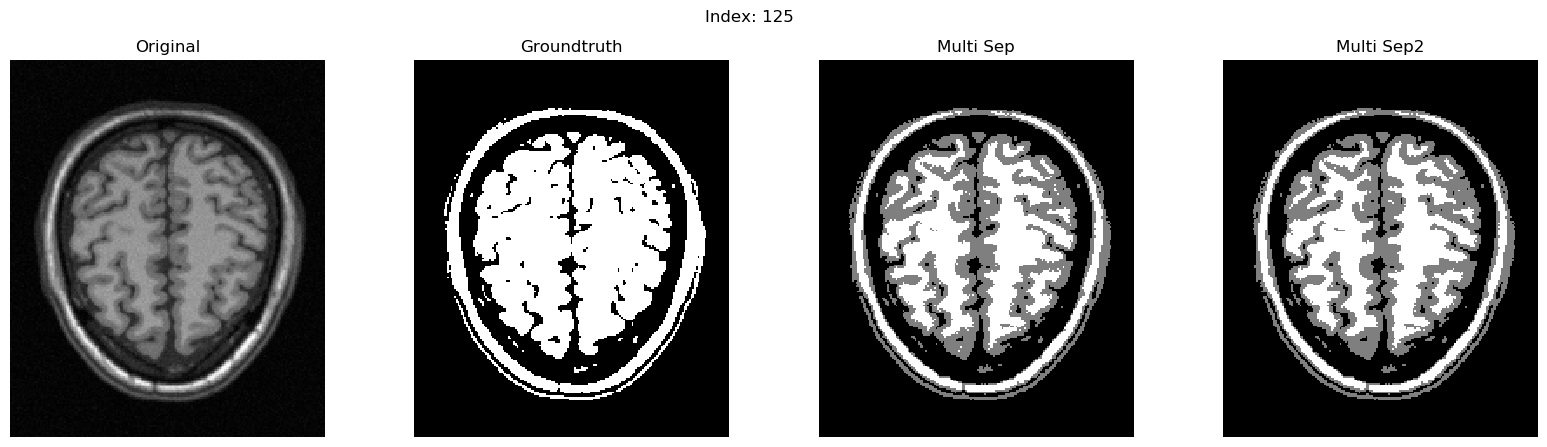

In [26]:
img_lst = param2['img_org']
mhue_t = param2['mhue_t']
region_t = param2['region_t']
gt_lst = param2['gt']
region_multi_t = param2['region_multi_t']
img_idx = param2['index']

for idx,img in enumerate(img_lst):
    region_maxt = region_t[idx]
    mhue_mint = mhue_t[idx]
    region_multi_maxt = region_multi_t[idx]
    gt = gt_lst[idx]
    plt.figure(figsize=(20,5))
    plt.suptitle('Index: {}'.format(img_idx[idx]))
    plt.subplot(141)
    plt.axis('off')
    plt.title('Original')
    plt.imshow(img,cmap='gray')
    plt.subplot(142)
    plt.axis('off')
    plt.title('Groundtruth')
    plt.imshow(gt,cmap='gray')
    
    n_sep = region_maxt.size
    sep = np.zeros(shape=img.shape)
    for n in range(n_sep):
        _,tmp = cv.threshold(img,region_maxt[n],255,0)
        sep[np.where(tmp==255)] = int(255*(n+1)/n_sep)
    plt.subplot(143)
    plt.axis('off')
    plt.title('Multi Sep')
    plt.imshow(sep,cmap='gray')
    
    
    n_sep = len(region_multi_maxt)
    sep = np.zeros(shape=img.shape)
    for n in range(n_sep):
        _,tmp = cv.threshold(img,region_multi_maxt[n],255,0)
        sep[np.where(tmp==255)] = int(255*(n+1)/n_sep)
    plt.subplot(144)
    plt.axis('off')
    plt.title('Multi Sep2')
    plt.imshow(sep,cmap='gray')
    

In [ ]:
#     # Weighted uncertainty
#     print('======================================')
#     print('Calculate Weighted uncertainty')
#     print('======================================')
#     uncertaintyw_lst = []
#     uncertaintyw_t = []
#     for idx,img in enumerate(img_lst):
#         uncertaintyw = mhue.get_uncertainty(img, off_center=True, info_w=True, stabs=stab_lst[idx], 
#                                             bdts_o=img_bdts_o[idx], bdts_b=img_bdts_b[idx],kernel_size=21,sigma=0.7)
#         uncertaintyw_lst.append(uncertaintyw)
#         print('Index: {}, done.'.format(img_idx[idx]))
    
#     # Weighted MHUE
#     print('======================================')
#     print('Calculate Weighted MHUE')
#     print('======================================')
#     mhuew_lst = []
#     for idx,img in enumerate(img_lst):
#         uncertaintyw = uncertaintyw_lst[idx]
#         scharr = scharr_lst[idx]
#         mhuew_i = mhue.get_HU(uncertainty=uncertaintyw, homogeneity=scharr)
#         mhuew_lst.append(mhuew_i)
#         print('Index: {}, done.'.format(img_idx[idx]))